# Transcrition Factors Promoter-Enhancer score across species

## Obtaining TSS annotation file

```
cd /scratch/Users/dara6367/fimo/Human
mkdir hg38-best_curated_Human-p1e-6_FIMO
mkdir hg38-best_curated_Human-p1e-5_FIMO

# Copies over files.
cp /Shares/txpnevol/genomes/hg38/annotation/hg38.ncbiRefSeq.TSS.3kb.oneEntry.bed .
cp /Shares/txpnevol/genomes/hg38/annotation/hg38.main.fa .

# Extend TSS to cover +/- 5kb around TSS.
awk -v OFS='\t' '{print $1,$2-3500,$3+3500,$4}' hg38.ncbiRefSeq.TSS.oneEntry.bed \
> hg38.ncbiRefSeq.TSS.10kb.oneEntry.bed.tmp1

# If the start coordinate is negative change it to zero.
awk -v OFS='\t' '{if ($2 < 0) print $1,0,$3,$4 ; if ($2 > 0) print $0}' \
hg38.ncbiRefSeq.TSS.10kb.oneEntry.bed.tmp1 \
> hg38.ncbiRefSeq.TSS.10kb.oneEntry.bed.tmp2

# Sorts and merges overlapping TSS.
sort -k1,1 -k2,2n hg38.ncbiRefSeq.TSS.10kb.oneEntry.bed.tmp2 > hg38.ncbiRefSeq.TSS.10kb.oneEntry.bed.tmp3
mergeBed -i hg38.ncbiRefSeq.TSS.10kb.oneEntry.bed.tmp3 > hg38.ncbiRefSeq.TSS.10kb.oneEntry.noFilt.bed

# Remove intermediary files.
rm hg38.ncbiRefSeq.TSS.10kb.oneEntry.bed.tmp1
rm hg38.ncbiRefSeq.TSS.10kb.oneEntry.bed.tmp2
rm hg38.ncbiRefSeq.TSS.10kb.oneEntry.bed.tmp3
rm hg38.ncbiRefSeq.TSS.oneEntry.bed
```

## Scanning genomes with FIMO for each TF

I used the following scripts, which I obtained from Ignacio Tripodi.

**extractMotifs.py**
```
def extractMotifs(jasparFile, individualMotifFile, motifHeader):
        with open(jasparFile,'r') as jaspar:
                for line in jaspar:
                        if 'MOTIF' in line:
                                motifFile = []
                                motifName = line.split(' ')[1]
                                motifFile.append(motifHeader)
                                motifFile.append(line + '\n')
                        if not line.strip():
                                individualMotifFileName = individualMotifFile + motifName.strip('\n') + '.meme'
                                with open(individualMotifFileName,'w') as newFile:
                                        for line2 in motifFile:
                                                newFile.write(str(line2))
                                next
                        elif not 'MOTIF' in line:
                                motifFile.append(line)

jasparFile = '/Users/dara6367/repos/TFEA/motif_files/best_curated_Human_edited.meme'
individualMotifFile = '/Users/dara6367/repos/TFEA/motif_files/best_curated_Human_separate/'
motifHeader = 'MEME version 4\n\nALPHABET= ACGT\n\nstrands: + -\n\nBackground letter frequencies:\nA 0.296 C 0.204 G 0.204 T 0.296\n\n'
extractMotifs(jasparFile, individualMotifFile, motifHeader)
```

**fimo-job-submitter.sbatch**
```
#SBATCH --nodes=1
#SBATCH --cpus-per-task=1
#SBATCH --mem=5gb
#SBATCH --time=1-20:00:00
#SBATCH --partition=long

module load python/2.7.14

python /Shares/txpnevol/daniel/scripts/fimo-job-submitter.py
```
**fimo-job-submitter.py**
```
import glob
import os
import time

if __name__ == "__main__":
    batch_size = 50
    bg_file = '/scratch/Users/dara6367/fimo/Chimp/background.panTro6.main.txt'
    output_dir = '/scratch/Users/dara6367/fimo/Chimp/panTro6-best_curated_Human-p1e-5_FIMO'
    meme_dir = '/scratch/Users/dara6367/fimo/best_curated_Human_separate'
    genome_fasta = '/scratch/Users/dara6367/fimo/Chimp/panTro6.main.fa'
    i = 1

    for motif_filename in glob.glob('%s/*.meme' % meme_dir):
        motif_name = os.path.basename(motif_filename).split('.')[0]
        print("RUNNING: sbatch -J %s_fimo --export=motif='%s',outdir='%s',memefile='%s',genomefasta='%s',bgfile='%s' /Shares/txpnevol/daniel/scripts/fimo-template.sbatch" % (motif_name, motif_name, output_dir, motif_filename, genome_fasta, bg_file))
        os.system("sbatch -J %s_fimo --export=motif='%s',outdir='%s',memefile='%s',genomefasta='%s',bgfile='%s' /Shares/txpnevol/daniel/scripts/fimo-template.sbatch" % (motif_name, motif_name, output_dir, motif_filename, genome_fasta, bg_file))

        if i % batch_size == 0:
            time.sleep(2500)
        i+=1
```
**fimo-template.sbatch**
```
#SBATCH --nodes=1
#SBATCH --cpus-per-task=1
#SBATCH --mem=15gb
#SBATCH --time=01:00:00
#SBATCH --partition=short

module load meme/5.0.3

fimo \
-max-stored-scores 10000000 \
--thresh 1e-5 \
--text \
--bgfile ${bgfile} \
${memefile} \
${genomefasta} \
> ${outdir}/${motif}.bed
```

Making a text file with the all the motif names.
```
# Makes a text file with only the motif names per line.
cd /scratch/Users/dara6367/fimo/Human
ls hg38-best_curated_Human-p1e-6_FIMO | sed 's/\t/\n/g' | cut -f1 -d'.' | sed -e 's/\x1b\[[0-9;]*m//g' \
> ../best_curated_Human_TF_names.txt
```

## Intersecting TSS and a given TF mofit instance set obtained with FIMO 

```
module load bedtools/2.28.0

# Defines variables.
species=OwlMonkey
assembly=Anan_2.0
dir=/scratch/Users/dara6367/fimo
alpha=p1e-6

mkdir -p ${dir}/${species}/${assembly}-best_curated_Human-${alpha}_intersect

# Loops through each TF.
for TF in `cat ${dir}/best_curated_Human_TF_names.txt`

	do

	# Makes a temporary actual BED file without header.
	tail -n +2 ${dir}/${species}/${assembly}-best_curated_Human-${alpha}_FIMO/${TF}.bed | cut -f3,4,5 \
	> ${dir}/${species}/${assembly}-best_curated_Human-${alpha}_intersect/${TF}.bed

	# Determines for each FIMO motif instance, 1 if intersecting with TSS, 0 if not.
	intersectBed -c \
	-a ${dir}/${species}/${assembly}-best_curated_Human-${alpha}_intersect/${TF}.bed \
	-b ${dir}/${species}/${assembly}.ncbiRefSeq.TSS.10kb.oneEntry.bed \
	> ${dir}/${species}/${assembly}-best_curated_Human-${alpha}_intersect/${TF}_${assembly}-${alpha}_intersect_TSS.10kb.txt.tmp

	# Formats intersection results with only counts for 1 and 0, and adds TF name inside file.
	cut -f4 ${dir}/${species}/${assembly}-best_curated_Human-${alpha}_intersect/${TF}_${assembly}-${alpha}_intersect_TSS.10kb.txt.tmp | \
	sort | uniq -c | sed 's/^ *//' | awk -v OFS='\t' '{ print $2, $1}' \
	> ${dir}/${species}/${assembly}-best_curated_Human-${alpha}_intersect/${TF}_${assembly}-${alpha}_intersect_TSS.10kb.txt.tmp2
	echo -e "TF\t${TF}" | cat - ${dir}/${species}/${assembly}-best_curated_Human-${alpha}_intersect/${TF}_${assembly}-${alpha}_intersect_TSS.10kb.txt.tmp2 \
	> ${dir}/${species}/${assembly}-best_curated_Human-${alpha}_intersect/${TF}_${assembly}-${alpha}_intersect_TSS.10kb.txt.tmp3
	cut -f2 ${dir}/${species}/${assembly}-best_curated_Human-${alpha}_intersect/${TF}_${assembly}-${alpha}_intersect_TSS.10kb.txt.tmp3 | tr -s '\n' '\t' \
	> ${dir}/${species}/${assembly}-best_curated_Human-${alpha}_intersect/${TF}_${assembly}-${alpha}_intersect_TSS.10kb.txt

	# Removes intermediary files.
	rm ${dir}/${species}/${assembly}-best_curated_Human-${alpha}_intersect/${TF}_${assembly}-${alpha}_intersect_TSS.10kb.txt.tmp
	rm ${dir}/${species}/${assembly}-best_curated_Human-${alpha}_intersect/${TF}_${assembly}-${alpha}_intersect_TSS.10kb.txt.tmp2
	rm ${dir}/${species}/${assembly}-best_curated_Human-${alpha}_intersect/${TF}_${assembly}-${alpha}_intersect_TSS.10kb.txt.tmp3
	rm ${dir}/${species}/${assembly}-best_curated_Human-${alpha}_intersect/${TF}.bed

done

# Adds a new line at the end of every TF 0/1 count table.
cd ${dir}/${species}/${assembly}-best_curated_Human-${alpha}_intersect
for file in `ls | sed "s/\t/\n/g" | sed -e "s/\x1b\[[0-9;]*m//g"`
	do 
	echo "" >> ${file}
done

# Concatenates all TF 0/1 count tables to be loaded in R.
cat * > ${dir}/${species}/TFs-best_curated_Human-${assembly}-FIMO_${alpha}-intersect_TSS.10kb.txt

# Removes intermediary directory.
rm -R ${dir}/${species}/${assembly}-best_curated_Human-${alpha}_intersect
```

In [1]:
suppressMessages(library(ggplot2))
suppressMessages(library(ggrepel))
suppressMessages(library(viridis))
suppressMessages(library(tidyr))
suppressMessages(library(ggplot2))
suppressMessages(library(dplyr))
suppressMessages(library(gridExtra))
suppressMessages(library(grid))
suppressMessages(library(cowplot))
suppressMessages(library(fgsea))
suppressMessages(library(scales))
suppressMessages(library(reshape2))
suppressMessages(library(pheatmap))
suppressMessages(library(data.table))
suppressMessages(library(seqinr))
suppressMessages(library(ggseqlogo))
suppressMessages(library(plyr))

In [2]:
# Makes data frame / dictionary with species, assembly, assembly size, number of TSS, and color.
speciesList <- c("Human","Chimp","Bonobo","Gorilla","Orangutan","Gibbon",
                 "Rhesus","Baboon","SquirrelMonkey","OwlMonkey","Cow","Chicken")

# Creates color scheme data frame that matches species with their color.
speciesDict <- data.frame(matrix(ncol = 7, nrow = length(speciesList)))
colnames(speciesDict) <- c("species","assembly","assemblySize","GC","nTSS","nTSSfilt","colorCode")
rownames(speciesDict) <- speciesList
speciesDict$species <- speciesList
speciesDict$assembly <- c("hg38","panTro6","panPan3","gorGor4","ponAbe3","nomLeu3",
                          "rheMac10","papAnu4","saiBol1","Anan_2.0","bosTau9","galGal6")
speciesDict$colorCode <- append(append("black",viridis(9)),c("gray60","gray40"))

# Stores the number of TSS used per genome assembly.
# Sums the length of every chromosome in the "main" chromosome size file per species.
for(species in speciesList) {
    speciesDict[species,"assemblySize"] <- sum(read.table(paste0("/Shares/txpnevol/genomes/",speciesDict[species,'assembly'],"/",speciesDict[species,'assembly'],".main.chrom.sizes"))$V2 / 1000000)
    speciesDict[species,"nTSS"] <- dim(read.table(paste0("/scratch/Users/dara6367/fimo/",species,"/",speciesDict[species,'assembly'],".ncbiRefSeq.TSS.10kb.oneEntry.noFilt.bed")))[1] / 1000
    speciesDict[species,"nTSSfilt"] <- dim(read.table(paste0("/scratch/Users/dara6367/fimo/",species,"/",speciesDict[species,'assembly'],".ncbiRefSeq.TSS.10kb.oneEntry.tfitFilt.bed")))[1] / 1000
    GCtable <- read.table(paste0("/scratch/Users/dara6367/fimo/",species,"/background.",speciesDict[species,'assembly'],".main.txt"))
    speciesDict[species,"GC"] <- GCtable[GCtable$V1 == "G","V2"]*2
}

Coordinate system already present. Adding new coordinate system, which will replace the existing one.



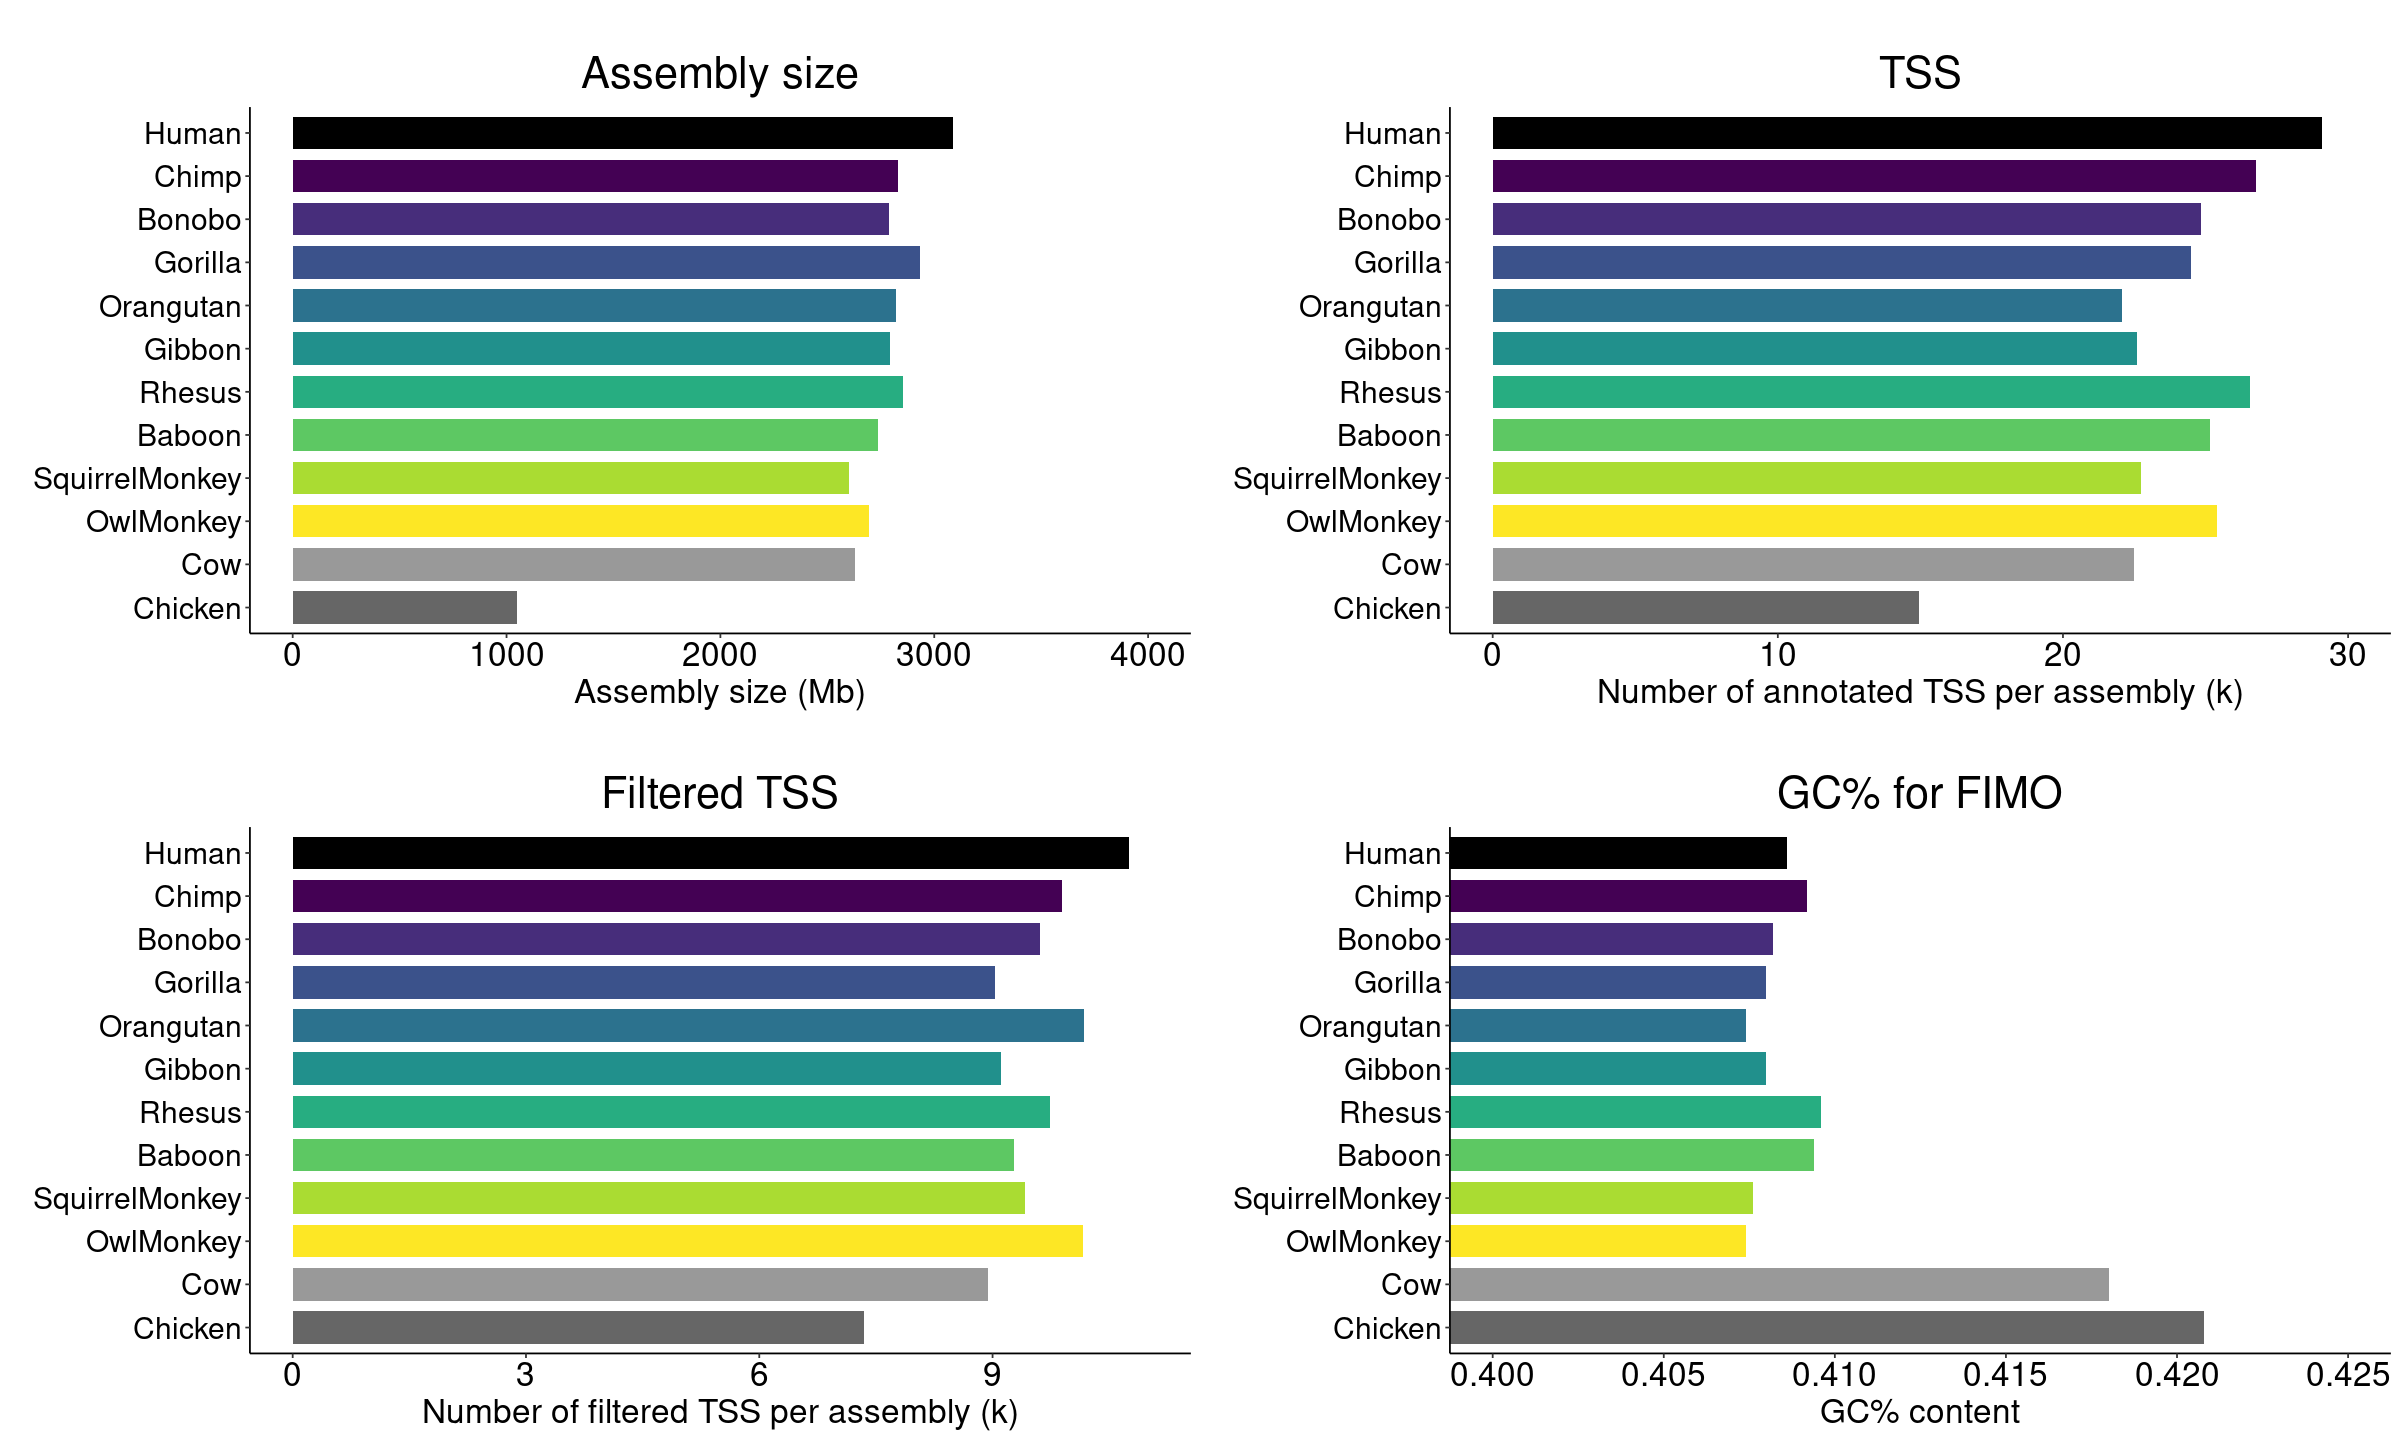

In [3]:
# Makes barplots.

speciesDict$species <- factor(speciesDict$species, 
                              levels = rev(speciesList))

assemblySize_plot <- ggplot(data = speciesDict, aes(x = species, y = assemblySize, fill = species)) + 
    geom_bar(stat = "identity", width = 0.75) +
    theme_classic() +
    coord_flip() +
    scale_fill_manual(values = rev(append(append("black",viridis(9)),c("gray60","gray40")))) +
    labs(title = "\nAssembly size",
       x = "",
       y = "Assembly size (Mb)") +
    ylim(0, round_any(max(speciesDict$assemblySize), 1000, f = ceiling)) +
    theme(legend.position = "none", 
        plot.title = element_text(size = 26, color = "black", hjust = 0.5),
        axis.text.y = element_text(color = "black", size = 18),
        axis.title.x = element_text(color = "black", size = 20, hjust = 0.5),
        axis.text.x = element_text(color = "black", size = 20))

nTSS_plot <- ggplot(data = speciesDict, aes(x = species, y = nTSS, fill = species)) + 
    geom_bar(stat = "identity", width = 0.75) +
    theme_classic() +
    coord_flip() +
    scale_fill_manual(values = rev(append(append("black",viridis(9)),c("gray60","gray40")))) +
    labs(title = "\nTSS",
       x = "",
       y = "Number of annotated TSS per assembly (k)") +
    ylim(0, round_any(max(speciesDict$nTSS), 1, f = ceiling)) +
    theme(legend.position = "none", 
        plot.title = element_text(size = 26, color = "black", hjust = 0.5),
        axis.text.y = element_text(color = "black", size = 18),
        axis.title.x = element_text(color = "black", size = 20, hjust = 0.5),
        axis.text.x = element_text(color = "black", size = 20))

nTSSfilt_plot <- ggplot(data = speciesDict, aes(x = species, y = nTSSfilt, fill = species)) + 
    geom_bar(stat = "identity", width = 0.75) +
    theme_classic() +
    coord_flip() +
    scale_fill_manual(values = rev(append(append("black",viridis(9)),c("gray60","gray40")))) +
    labs(title = "\nFiltered TSS",
       x = "",
       y = "Number of filtered TSS per assembly (k)") +
    ylim(0, round_any(max(speciesDict$nTSSfilt), 1, f = ceiling)) +
    theme(legend.position = "none", 
        plot.title = element_text(size = 26, color = "black", hjust = 0.5),
        axis.text.y = element_text(color = "black", size = 18),
        axis.title.x = element_text(color = "black", size = 20, hjust = 0.5),
        axis.text.x = element_text(color = "black", size = 20))

GC_plot <- ggplot(data = speciesDict, aes(x = species, y = GC, fill = species)) + 
    geom_bar(stat = "identity", width = 0.75) +
    theme_classic() +
    coord_flip() +
    scale_fill_manual(values = rev(append(append("black",viridis(9)),c("gray60","gray40")))) +
    labs(title = "\nGC% for FIMO",
       x = "",
       y = "GC% content") +
    coord_flip(ylim = c(0.4, 0.425)) +
    theme(legend.position = "none", 
        plot.title = element_text(size = 26, color = "black", hjust = 0.5),
        axis.text.y = element_text(color = "black", size = 18),
        axis.title.x = element_text(color = "black", size = 20, hjust = 0.5),
        axis.text.x = element_text(color = "black", size = 20))

options(repr.plot.width = 20, repr.plot.height = 12)
grid.arrange(assemblySize_plot, nTSS_plot, nTSSfilt_plot, GC_plot, nrow = 2)

In [4]:
# Defines variables.
TFdb <- "best_curated_Human"
alpha <- "p1e-6"
TSSfilt <- "noFilt"
bg <- "bgtm"
motifs <- read.table(paste0("/scratch/Users/dara6367/fimo/",TFdb,"_TF_names.txt"))

Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message:
“Removed 3 rows containing missing values (geom_bar).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”


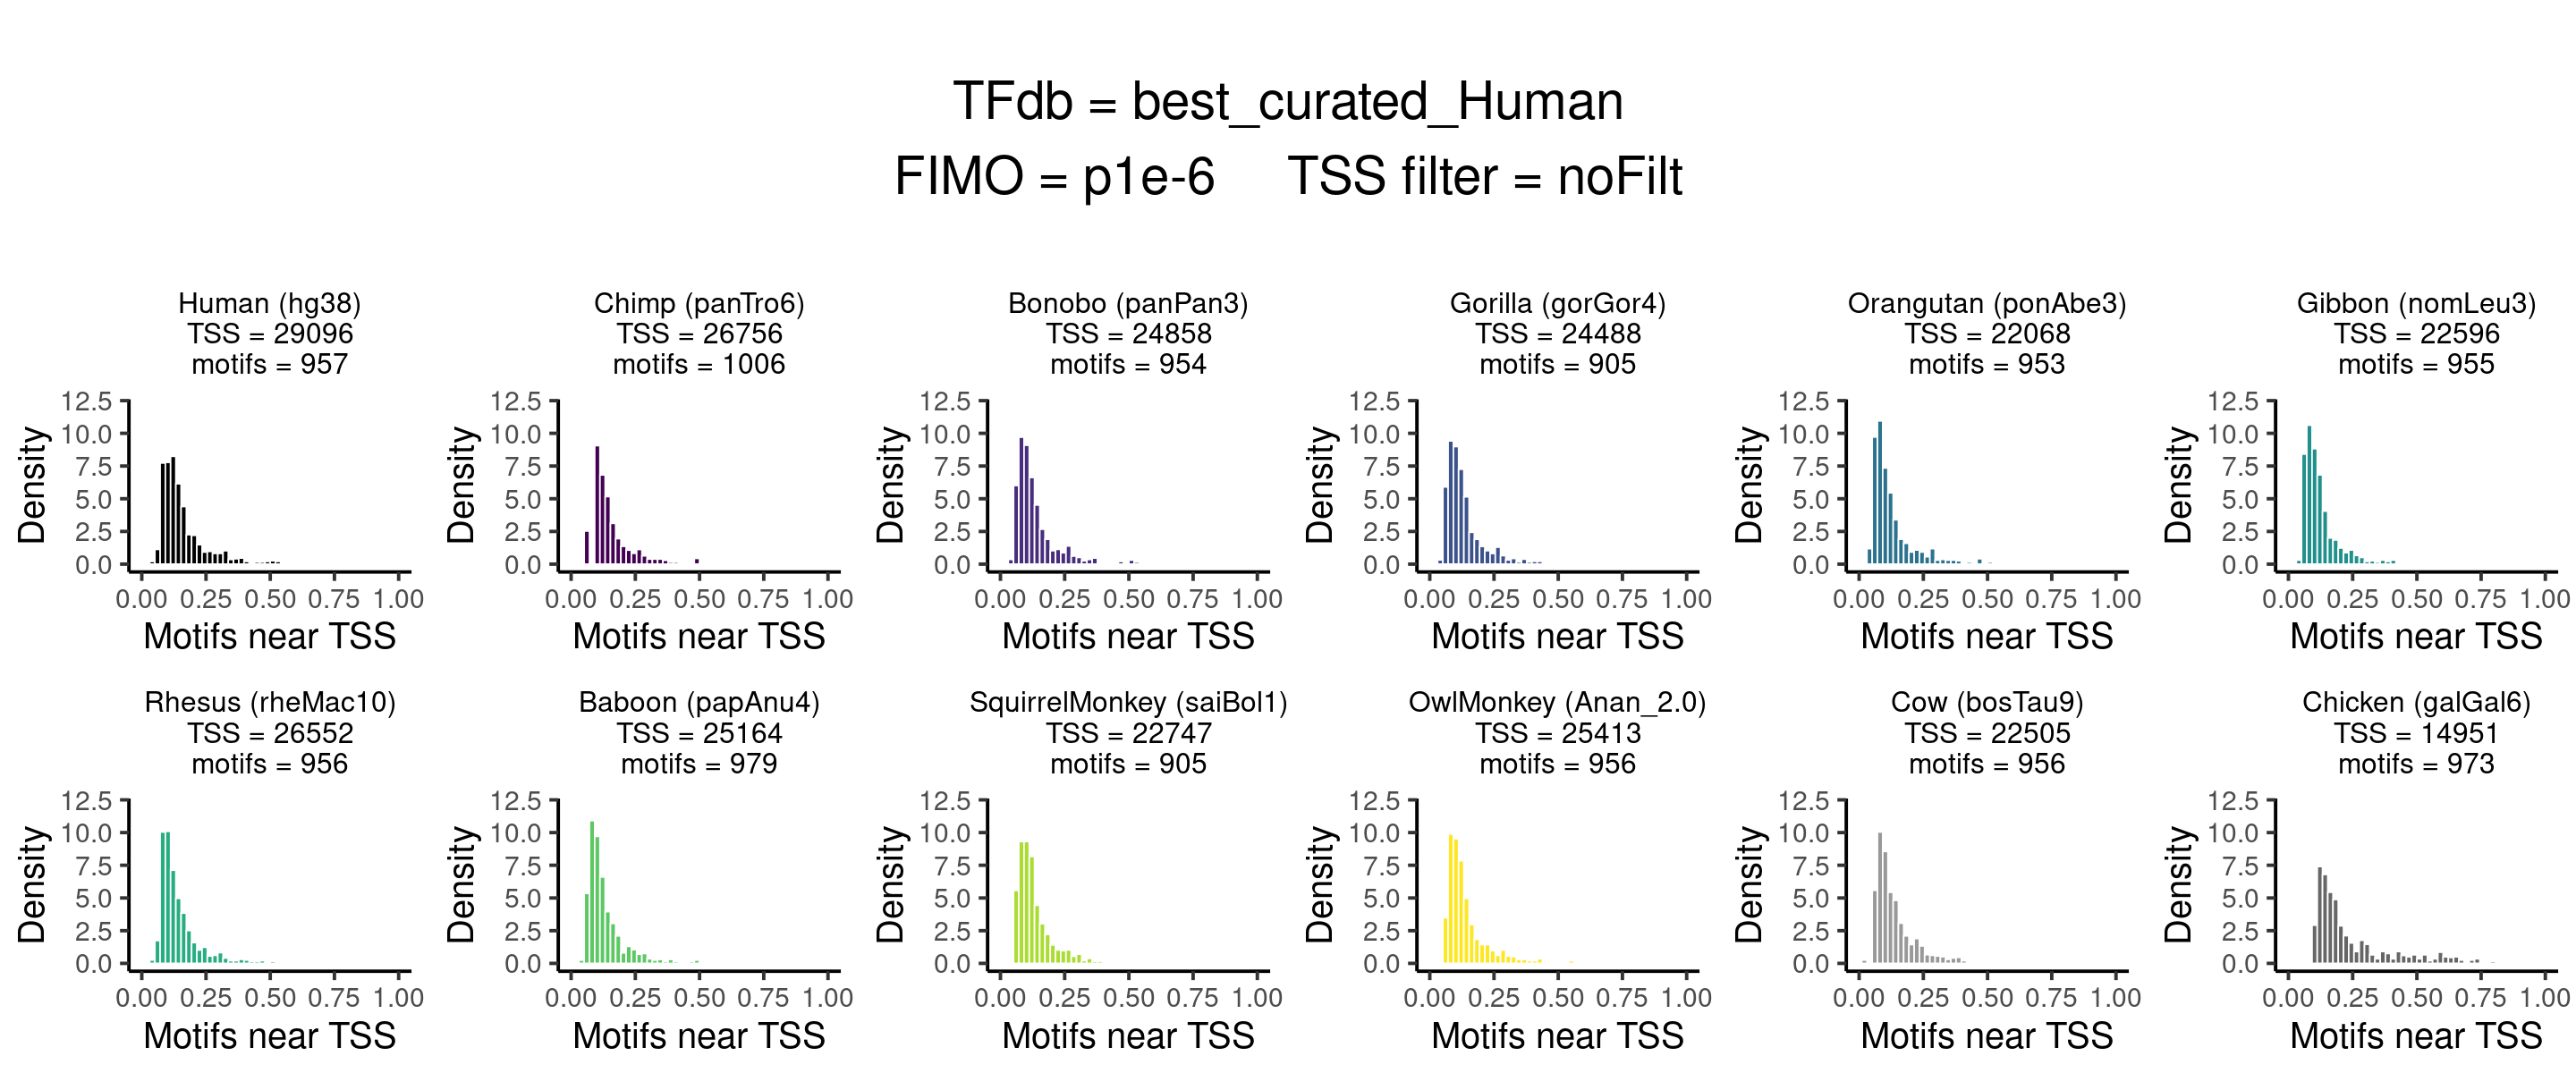

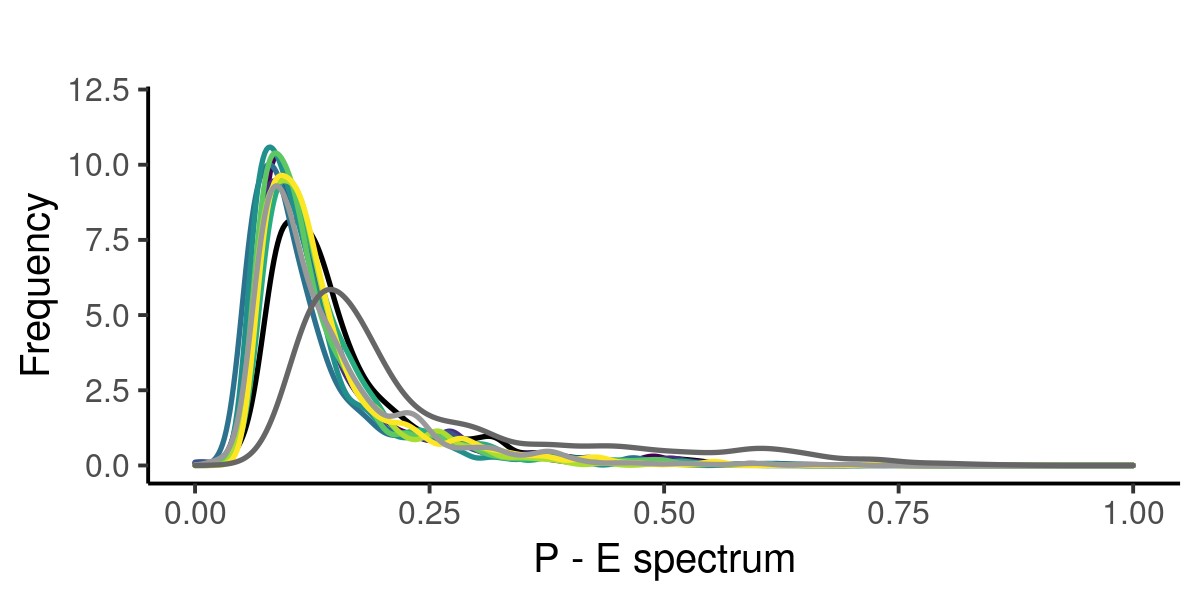

In [17]:
# Loads motif-TSS intersection table for a given species.

yLim <- 12

# Loops through each species and plots all histograms.
for(species in speciesList) {
    if(TSSfilt == "noFilt") { nTSS <- "nTSS" }
    if(TSSfilt == "tfitFilt") { nTSS <- "nTSSfilt" }
    assembly <- speciesDict[species,"assembly"]
    colorCode <- speciesDict[species,"colorCode"]

    # Reads in FIMO-TSS intersection results.
    intersectionTable <- read.table(paste0("/scratch/Users/dara6367/fimo/",species,"/TFs-",species,"-",speciesDict[species,"assembly"],"-TSS.10kb-",TSSfilt,"-",TFdb,"-FIMO_",alpha,"-intersect.txt"), 
                                    row.names = NULL, header = TRUE, sep = "\t", fill = TRUE, stringsAsFactors = FALSE, na.strings = "")
    colnames(intersectionTable) <- c("motif","enhancer","promoter","extra")
    intersectionTable <- intersectionTable[,c("motif","enhancer","promoter")]
    
    # Fills in total and fraction columns.
    intersectionTable$total <- intersectionTable$promoter + intersectionTable$enhancer
    intersectionTable$fraction <- intersectionTable$promoter / intersectionTable$total

    # Removes motifs without data.
    intersectionTable <- intersectionTable[complete.cases(intersectionTable$promoter),]
    assign(paste0("intersectionTable_",species), intersectionTable)

    # Stores density histogram.
    hist <- ggplot(intersectionTable, aes(x = fraction)) +
        geom_histogram(aes(y = ..density..), bins = 50, fill = colorCode, color = "white") +
        theme_classic(base_size = 24) +
        theme(plot.title = element_text(size = 19, hjust = 0.5),
              axis.text.y = element_text(size = 18),
              axis.text.x = element_text(size = 18)) +
        xlim(0, 1.0) +
        ylim(0, yLim) +
        labs(title = paste0(species," (",assembly,")\nTSS = ",speciesDict[species,nTSS]*1000,"\nmotifs = ",dim(intersectionTable)[1]),
           x = "Motifs near TSS",
           y = "Density")
    assign(paste0("hist_",species), hist) }

# Plots all histogram in a grid.
options(repr.plot.width = 24, repr.plot.height = 10)
grid.arrange(hist_Human, hist_Chimp, hist_Bonobo, hist_Gorilla, hist_Orangutan, hist_Gibbon,
             hist_Rhesus, hist_Baboon, hist_SquirrelMonkey, hist_OwlMonkey, hist_Cow, hist_Chicken,
             ncol = 6, nrow = 2,
             top = textGrob(paste0("\nTFdb = ",TFdb,"\nFIMO = ",alpha,"     TSS filter = ",TSSfilt,"\n"), 
                            gp = gpar(fontsize = 35)))

# Plots all density histograms overlaid.
options(repr.plot.width = 10, repr.plot.height = 5)
ggplot() +
    geom_density(data = intersectionTable_Human, aes(x = fraction, y = ..density..), lwd = 1.5, color = speciesDict["Human","colorCode"]) +
    geom_density(data = intersectionTable_Chimp, aes(x = fraction, y = ..density..), lwd = 1.5, color = speciesDict["Chimp","colorCode"]) +
    geom_density(data = intersectionTable_Bonobo, aes(x = fraction, y = ..density..), lwd = 1.5, color = speciesDict["Bonobo","colorCode"]) +
    geom_density(data = intersectionTable_Gorilla, aes(x = fraction, y = ..density..), lwd = 1.5, color = speciesDict["Gorilla","colorCode"]) +
    geom_density(data = intersectionTable_Orangutan, aes(x = fraction, y = ..density..), lwd = 1.5, color = speciesDict["Orangutan","colorCode"]) +
    geom_density(data = intersectionTable_Gibbon, aes(x = fraction, y = ..density..), lwd = 1.5, color = speciesDict["Gibbon","colorCode"]) +
    geom_density(data = intersectionTable_Rhesus, aes(x = fraction, y = ..density..), lwd = 1.5, color = speciesDict["Rhesus","colorCode"]) +
    geom_density(data = intersectionTable_Baboon, aes(x = fraction, y = ..density..), lwd = 1.5, color = speciesDict["Baboon","colorCode"]) +
    geom_density(data = intersectionTable_SquirrelMonkey, aes(x = fraction, y = ..density..), lwd = 1.5, color = speciesDict["SquirrelMonkey","colorCode"]) +
    geom_density(data = intersectionTable_OwlMonkey, aes(x = fraction, y = ..density..), lwd = 1.5, color = speciesDict["OwlMonkey","colorCode"]) +
    geom_density(data = intersectionTable_Cow, aes(x = fraction, y = ..density..), lwd = 1.5, color = speciesDict["Cow","colorCode"]) +
    geom_density(data = intersectionTable_Chicken, aes(x = fraction, y = ..density..), lwd = 1.5, color = speciesDict["Chicken","colorCode"]) +
    theme_classic(base_size = 24) +
    theme(plot.title = element_text(hjust = 0.5)) +
    xlim(0, 1.0) +
    ylim(0, yLim) +
    labs(title = "",
       x = "P - E spectrum",
       y = "Frequency")

Time difference of 1.795686 mins

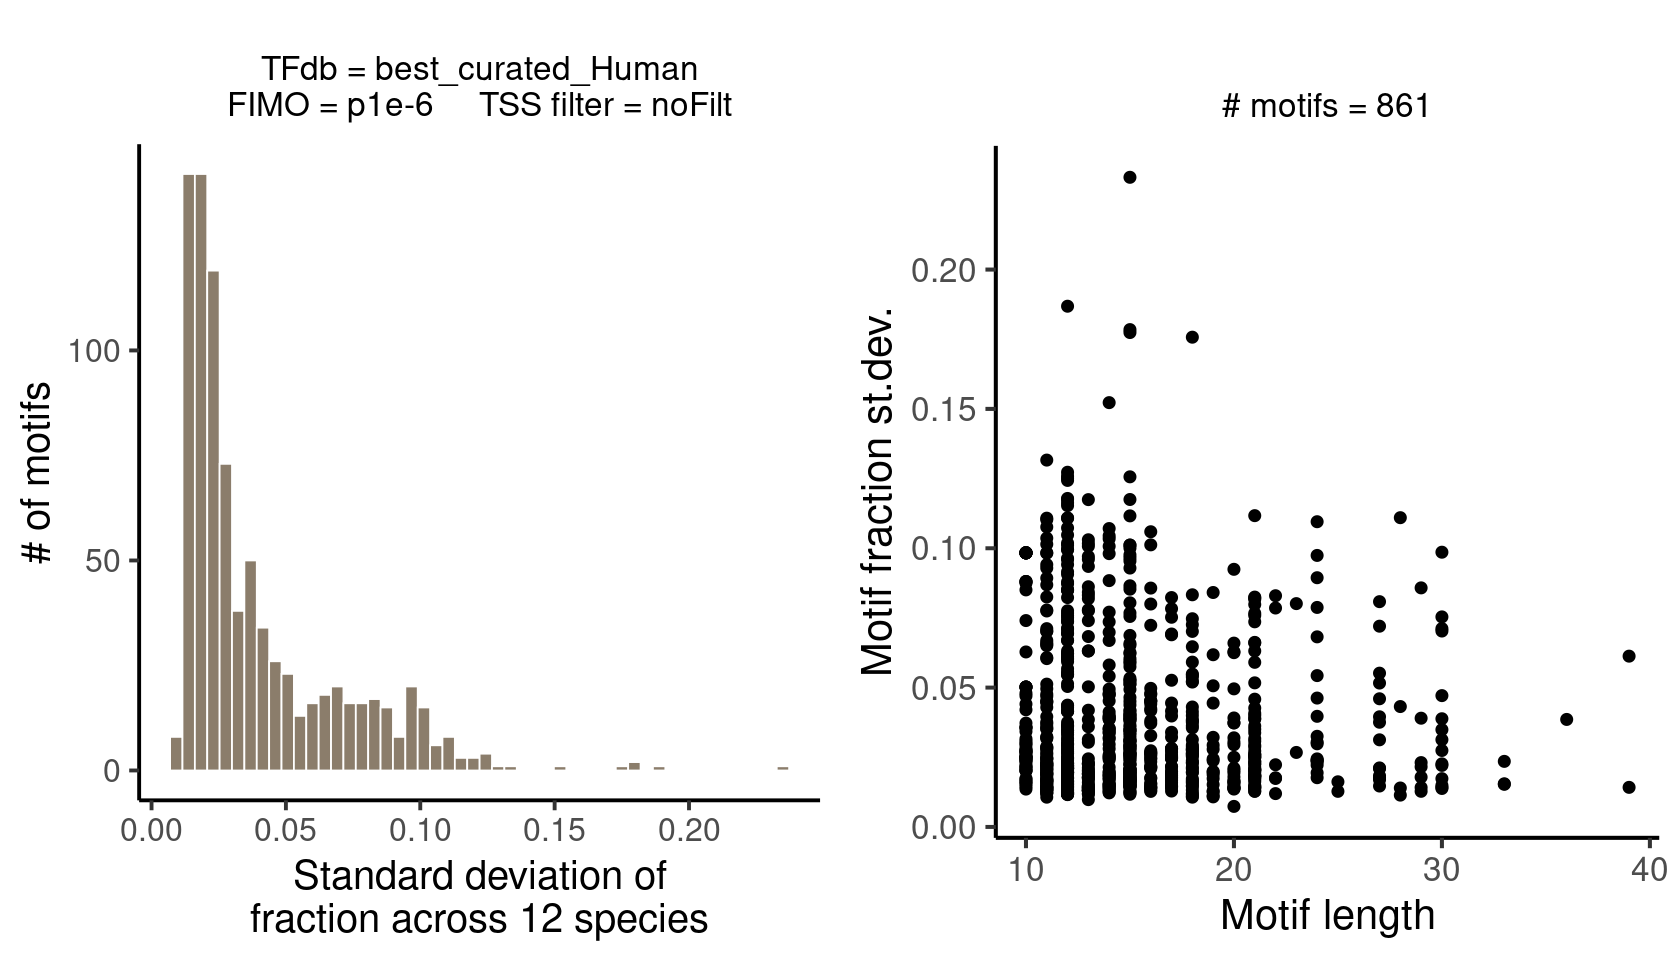

In [19]:
# Obtaining all fractions for all species onto a single matrix.

start.time <- Sys.time()

# Initializes data frame that will contain the fractions for all TF motifs for all species.
allFractions <- data.frame(matrix(ncol = length(speciesList) + 1, nrow = dim(intersectionTable)[1]))
colnames(allFractions) <- c(speciesList,"stdev")
rownames(allFractions) <- intersectionTable$motif

# Adds each motif score to each species.
for(motif in intersectionTable$motif) {
    for(species in speciesList) {
        # Reads in FIMO-TSS intersection results.
        intersectionTable <- read.table(paste0("/scratch/Users/dara6367/fimo/",species,"/TFs-",species,"-",speciesDict[species,"assembly"],"-TSS.10kb-",TSSfilt,"-",TFdb,"-FIMO_",alpha,"-intersect.txt"), 
                                        row.names = NULL, header = TRUE, sep = "\t", fill = TRUE, stringsAsFactors = FALSE, na.strings = "")
        colnames(intersectionTable) <- c("motif","enhancer","promoter","extra")
        intersectionTable <- intersectionTable[,c("motif","enhancer","promoter")]
        
        # Fills in total and fraction columns.
        intersectionTable$total <- intersectionTable$promoter + intersectionTable$enhancer
        intersectionTable$fraction <- intersectionTable$promoter / intersectionTable$total
        
        # Extracts fraction from chosen motif for a given species.
        allFractions[motif,species] <- intersectionTable[intersectionTable$motif == motif,"fraction"] }
    allFractions[motif,"stdev"] <- sd(as.numeric(allFractions[rownames(allFractions) == motif,]), na.rm = TRUE) }

# Removes TF motif rows that have NAs.
allFractions <- allFractions[complete.cases(allFractions),]
# Sorts TF motif entries by st.dev. in decreasing order.
allFractions <- allFractions[order(allFractions$stdev, decreasing = TRUE),]

# Loads table with motif lengths.
motifLengths <- read.table(paste0("/Users/dara6367/repos/TFEA/motif_files/",TFdb,"_lengths.txt"), 
                          header = FALSE, sep = "\t", fill = TRUE, stringsAsFactors = FALSE, na.strings = "")
colnames(motifLengths) <- c("motif","length")

# Adds the motif length to the big data frame as a last new column.
allFractions$length <- NA
for(motif in rownames(allFractions)) {
    allFractions[motif,"length"] <- motifLengths[motifLengths$motif == motif,"length"] }

# Plots distribution of st.dev. for all TF motifs.
hist <- ggplot(allFractions, aes(x = stdev)) +
    geom_histogram(bins = 50, fill = "bisque4", color = "white") +
    theme_classic(base_size = 24) +
    theme(plot.title = element_text(size = 20, hjust = 0.5)) +
    labs(title = paste0("\nTFdb = ",TFdb,"\nFIMO = ",alpha,"     TSS filter = ",TSSfilt),
       x = "Standard deviation of\nfraction across 12 species",
       y = "# of motifs")

# Plots correlation of motifs st.dev. and motif length.
scatter <- ggplot(allFractions, aes(y = stdev, x = length)) + 
  geom_point(size = 3) +
  labs(title = paste0("\n\n# motifs = ", dim(allFractions)[1]),
       y = "Motif fraction st.dev.",
       x = "Motif length") + 
  theme_classic(base_size = 25) +
  theme(plot.title = element_text(size = 20, hjust = 0.5))

options(repr.plot.width = 14, repr.plot.height = 8)
grid.arrange(hist, scatter, ncol = 2, nrow = 1)

end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


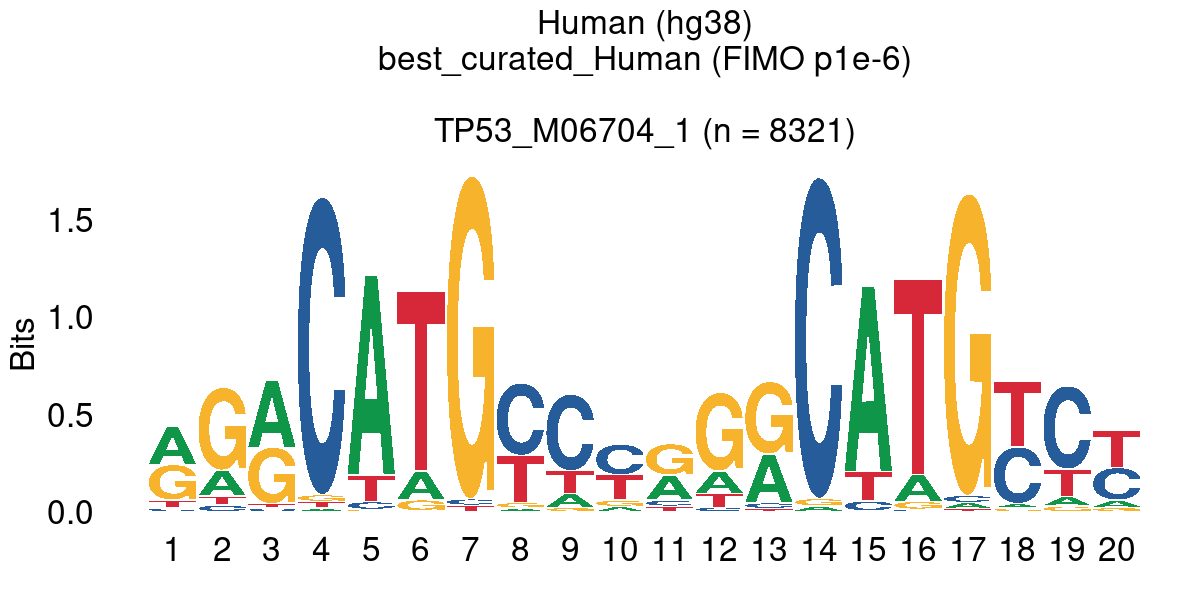

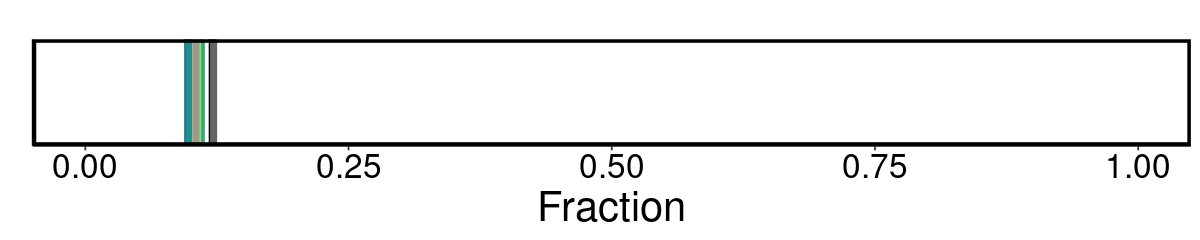

In [21]:
# Defines variables.
species <- "Human"
motif <- "TP53_M06704_1"

#####################################################
            # Individual motif logo
#####################################################

# Loads in FIMO file, and makes it a data frame.
fimoTable <- read.table(paste0("/scratch/Users/dara6367/fimo/",species,"/",speciesDict[species,"assembly"],"-",TFdb,"-",bg,"-",alpha,"_FIMO/",motif,".bed"), 
                        header = TRUE, sep = "\t", fill = TRUE, stringsAsFactors = FALSE, na.strings = "")
colnames(fimoTable) <- c("motif_id","motif_alt_id","sequence_name","start","stop","strand","score","p_value","q_value","matched_sequence")

# If the motif instance is in the negative strand, then it reverse complements it before storing it.
for(entry in seq(1:dim(fimoTable)[1])) {
   if(fimoTable[entry,"strand"] == "+") {
            fimoTable[entry,"matched_sequence"] <- toupper(fimoTable[entry,"matched_sequence"]) }
    if(fimoTable[entry,"strand"] == "-") {
            fimoTable[entry,"matched_sequence"] <- paste(toupper(rev(comp(s2c(fimoTable[entry,"matched_sequence"])))), collapse = "") } }

# Stores logo plot.
options(repr.plot.width = 10, repr.plot.height = 5)
ggseqlogo(fimoTable$matched_sequence, 
              method = "bits", 
              font = "helvetica_bold",
              size = 20) +
    ggtitle(paste0(species," (",speciesDict[species,"assembly"],")\n",TFdb," (FIMO ",alpha,")\n\n",motif," (n = ",dim(fimoTable)[1],")")) +
    theme(plot.title = element_text(size = 20, hjust = 0.5),
          axis.text.x = element_text(color = "black", size = 20),
          axis.text.y = element_text(color = "black", size = 20),
          axis.title.y = element_text(color = "black", size = 20))

#####################################################
            # Individual motif barcode
#####################################################

# Stores barcode plot with the chosen motif fraction for all species.
options(repr.plot.width = 10, repr.plot.height = 2)
ggplot() +
    geom_vline(size = 2, linetype = "solid", xintercept = allFractions[motif,"Human",], color = speciesDict["Human","colorCode"]) +
    geom_vline(size = 2, linetype = "solid", xintercept = allFractions[motif,"Chimp"], color = speciesDict["Chimp","colorCode"]) +
    geom_vline(size = 2, linetype = "solid", xintercept = allFractions[motif,"Bonobo"], color = speciesDict["Bonobo","colorCode"]) +
    geom_vline(size = 2, linetype = "solid", xintercept = allFractions[motif,"Gorilla"], color = speciesDict["Gorilla","colorCode"]) +
    geom_vline(size = 2, linetype = "solid", xintercept = allFractions[motif,"Orangutan"], color = speciesDict["Orangutan","colorCode"]) +
    geom_vline(size = 2, linetype = "solid", xintercept = allFractions[motif,"Gibbon"], color = speciesDict["Gibbon","colorCode"]) +
    geom_vline(size = 2, linetype = "solid", xintercept = allFractions[motif,"Rhesus"], color = speciesDict["Rhesus","colorCode"]) +
    geom_vline(size = 2, linetype = "solid", xintercept = allFractions[motif,"Baboon"], color = speciesDict["Baboon","colorCode"]) +
    geom_vline(size = 2, linetype = "solid", xintercept = allFractions[motif,"SquirrelMonkey"], color = speciesDict["SquirrelMonkey","colorCode"]) +
    geom_vline(size = 2, linetype = "solid", xintercept = allFractions[motif,"OwlMonkey"], color = speciesDict["OwlMonkey","colorCode"]) +
    geom_vline(size = 2, linetype = "solid", xintercept = allFractions[motif,"Cow"], color = speciesDict["Cow","colorCode"]) +
    geom_vline(size = 2, linetype = "solid", xintercept = allFractions[motif,"Chicken"], color = speciesDict["Chicken","colorCode"]) +
    theme_classic() +
    labs(title = paste0(""),
         x = "Fraction",
         y = "") +
    scale_x_continuous(limits = c(0,1)) +
    theme(legend.position = "none",
          axis.title.x = element_text(color = "black", size = 25, hjust = 0.5),
          axis.text.x = element_text(color = "black", size = 20),
          panel.border = element_rect(colour = "black", fill = NA, size = 2))

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = F

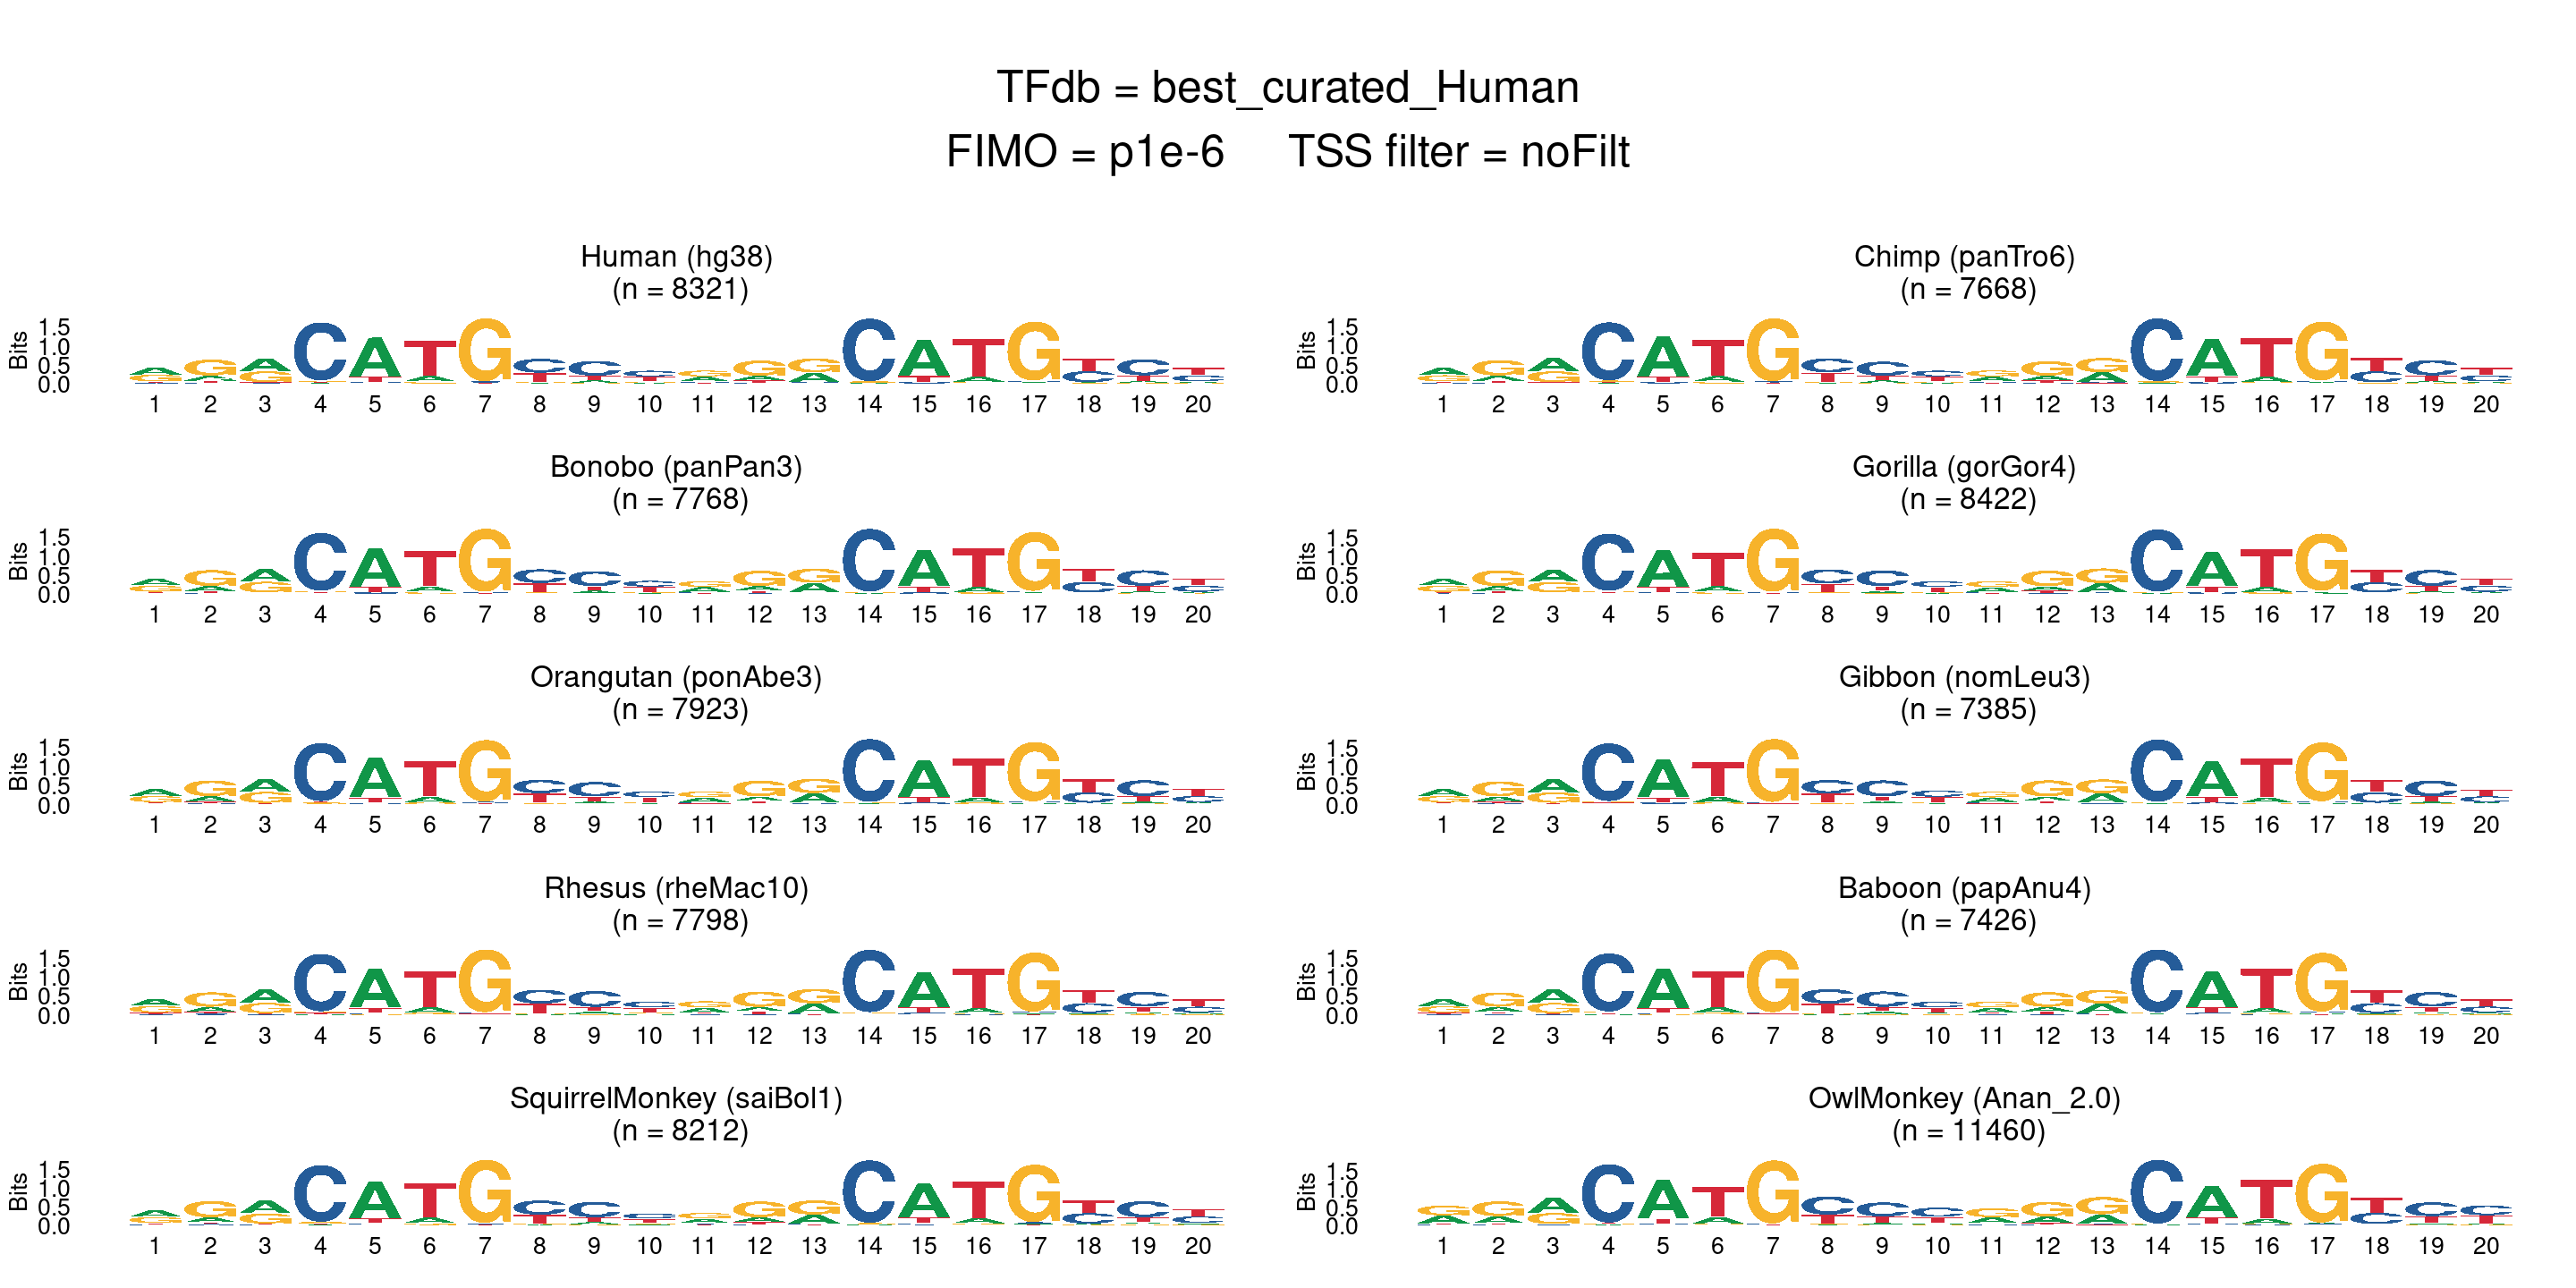

In [28]:
#####################################################
            # All species motif logos
#####################################################

motif <- "TP53_M06704_1"

for(species in speciesList) {
    # Loads in FIMO file, and makes it a data frame.
    fimoTable <- read.table(paste0("/scratch/Users/dara6367/fimo/",species,"/",speciesDict[species,"assembly"],"-",TFdb,"-",bg,"-",alpha,"_FIMO/",motif,".bed"), 
                            header = TRUE, sep = "\t", fill = TRUE, stringsAsFactors = FALSE, na.strings = "")
    colnames(fimoTable) <- c("motif_id","motif_alt_id","sequence_name","start","stop","strand","score","p_value","q_value","matched_sequence")

    # If the motif instance is in the negative strand, then it reverse complements it before storing it.
    for(entry in seq(1:dim(fimoTable)[1])) {
       if(fimoTable[entry,"strand"] == "+") {
                fimoTable[entry,"matched_sequence"] <- toupper(fimoTable[entry,"matched_sequence"]) }
        if(fimoTable[entry,"strand"] == "-") {
                fimoTable[entry,"matched_sequence"] <- paste(toupper(rev(comp(s2c(fimoTable[entry,"matched_sequence"])))), collapse = "") } }

    # Stores logo plot.
    logo <- ggseqlogo(fimoTable$matched_sequence, 
                  method = "bits", 
                  font = "helvetica_bold",
                  size = 20) +
        ggtitle(paste0(species," (",speciesDict[species,"assembly"],")\n (n = ",dim(fimoTable)[1],")")) +
        theme(plot.title = element_text(size = 20, hjust = 0.5),
              axis.text.x = element_text(color = "black", size = 16),
              axis.text.y = element_text(color = "black", size = 16),
              axis.title.y = element_text(color = "black", size = 16))

    assign(paste0("logo_",species), logo) }

# Plots top and bottom chosen barcodes in a grid.
options(repr.plot.width = 24, repr.plot.height = 12)
grid.arrange(logo_Human, logo_Chimp, logo_Bonobo, logo_Gorilla, logo_Orangutan,
             logo_Gibbon, logo_Rhesus, logo_Baboon, logo_SquirrelMonkey, logo_OwlMonkey,
             ncol = 2, nrow = 5,
             top = textGrob(paste0("\nTFdb = ",TFdb,"\nFIMO = ",alpha,"     TSS filter = ",TSSfilt,"\n"), 
                            gp = gpar(fontsize = 30)))

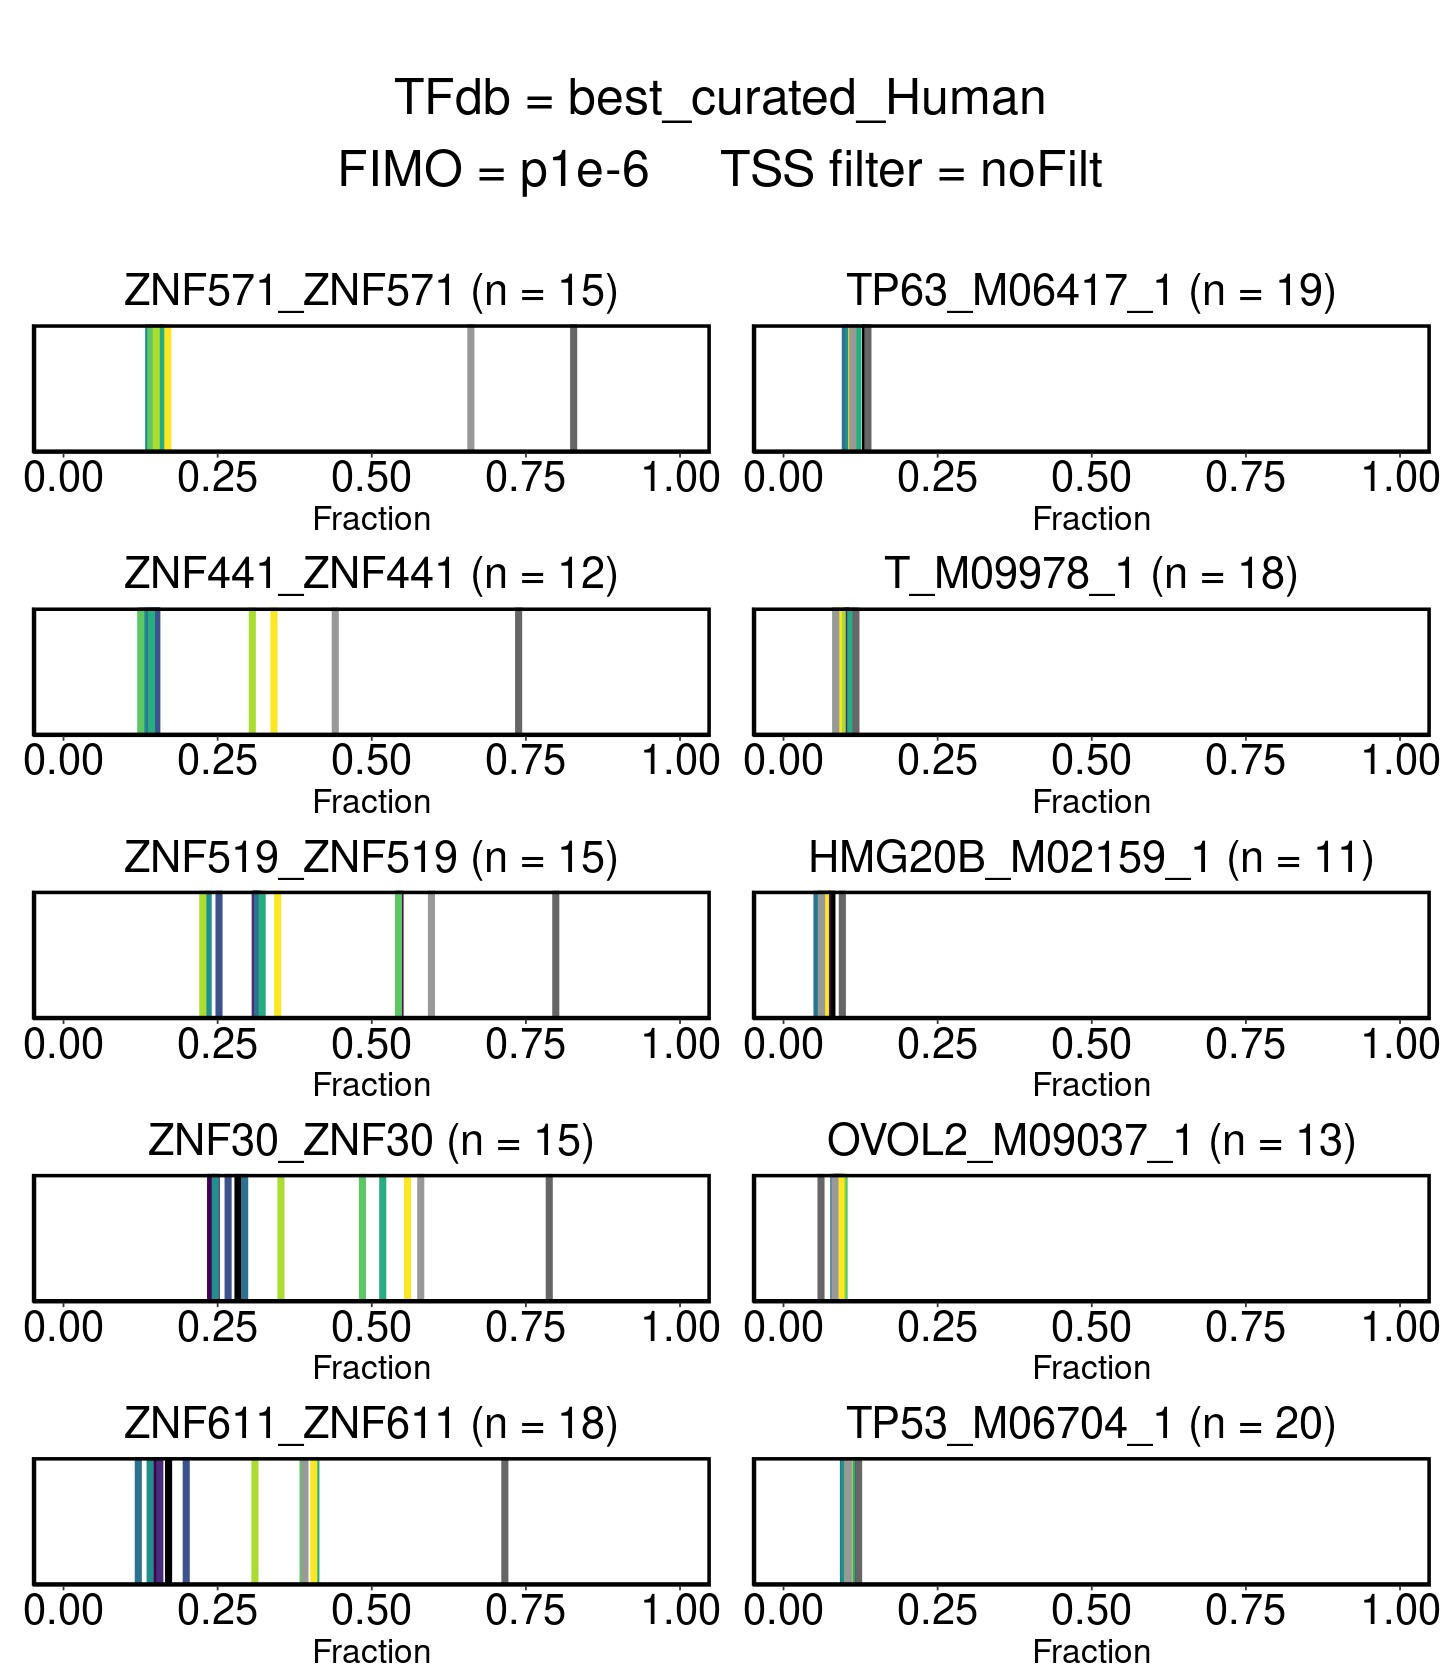

In [22]:
#####################################################
              # Multiple P-E barcodes
#####################################################

# Obtains the TF motif names of top 5 and bottom 5 sorted by st.dev.
topFiveTF <- head(rownames(allFractions), 5)
bottomFiveTF <- tail(rownames(allFractions), 5)
chosenTF <- c(topFiveTF,bottomFiveTF)
counter <- 1

for(motif in chosenTF) {
    plot <- ggplot() +
        geom_vline(size = 2, linetype = "solid", xintercept = allFractions[motif,"Human"], color = speciesDict["Human","colorCode"]) +
        geom_vline(size = 2, linetype = "solid", xintercept = allFractions[motif,"Chimp"], color = speciesDict["Chimp","colorCode"]) +
        geom_vline(size = 2, linetype = "solid", xintercept = allFractions[motif,"Bonobo"], color = speciesDict["Bonobo","colorCode"]) +
        geom_vline(size = 2, linetype = "solid", xintercept = allFractions[motif,"Gorilla"], color = speciesDict["Gorilla","colorCode"]) +
        geom_vline(size = 2, linetype = "solid", xintercept = allFractions[motif,"Orangutan"], color = speciesDict["Orangutan","colorCode"]) +
        geom_vline(size = 2, linetype = "solid", xintercept = allFractions[motif,"Gibbon"], color = speciesDict["Gibbon","colorCode"]) +
        geom_vline(size = 2, linetype = "solid", xintercept = allFractions[motif,"Rhesus"], color = speciesDict["Rhesus","colorCode"]) +
        geom_vline(size = 2, linetype = "solid", xintercept = allFractions[motif,"Baboon"], color = speciesDict["Baboon","colorCode"]) +
        geom_vline(size = 2, linetype = "solid", xintercept = allFractions[motif,"SquirrelMonkey"], color = speciesDict["SquirrelMonkey","colorCode"]) +
        geom_vline(size = 2, linetype = "solid", xintercept = allFractions[motif,"OwlMonkey"], color = speciesDict["OwlMonkey","colorCode"]) +
        geom_vline(size = 2, linetype = "solid", xintercept = allFractions[motif,"Cow"], color = speciesDict["Cow","colorCode"]) +
        geom_vline(size = 2, linetype = "solid", xintercept = allFractions[motif,"Chicken"], color = speciesDict["Chicken","colorCode"]) +
        theme_classic() +
        labs(title = paste0(motif," (n = ",allFractions[motif,"length"],")"),
             x = "Fraction",
             y = "") +
        scale_x_continuous(limits = c(0,1)) +
        theme(legend.position = "none", 
              plot.title = element_text(size = 26, color = "black", hjust = 0.5),
              axis.title.x = element_text(color = "black", size = 20, hjust = 0.5),
              axis.text.x = element_text(color = "black", size = 25),
              panel.border = element_rect(colour = "black", fill = NA, size = 2))
    assign(paste0("plot_",counter), plot)
    # Updates counter to assign a different plot ID for them plotting all together.
    counter <- counter + 1 }

# Plots top and bottom chosen barcodes in a grid.
options(repr.plot.width = 12, repr.plot.height = 14)
grid.arrange(plot_1, plot_6, plot_2, plot_7, plot_3,
             plot_8, plot_4, plot_9, plot_5, plot_10,
             ncol = 2, nrow = 5,
             top = textGrob(paste0("\nTFdb = ",TFdb,"\nFIMO = ",alpha,"     TSS filter = ",TSSfilt,"\n"), 
                            gp = gpar(fontsize = 30)))

# MD-score across species

ERROR: Error in pheatmap(mat = md_species_t, color = magmas, breaks = seq(from = 0, : object 'magmas' not found


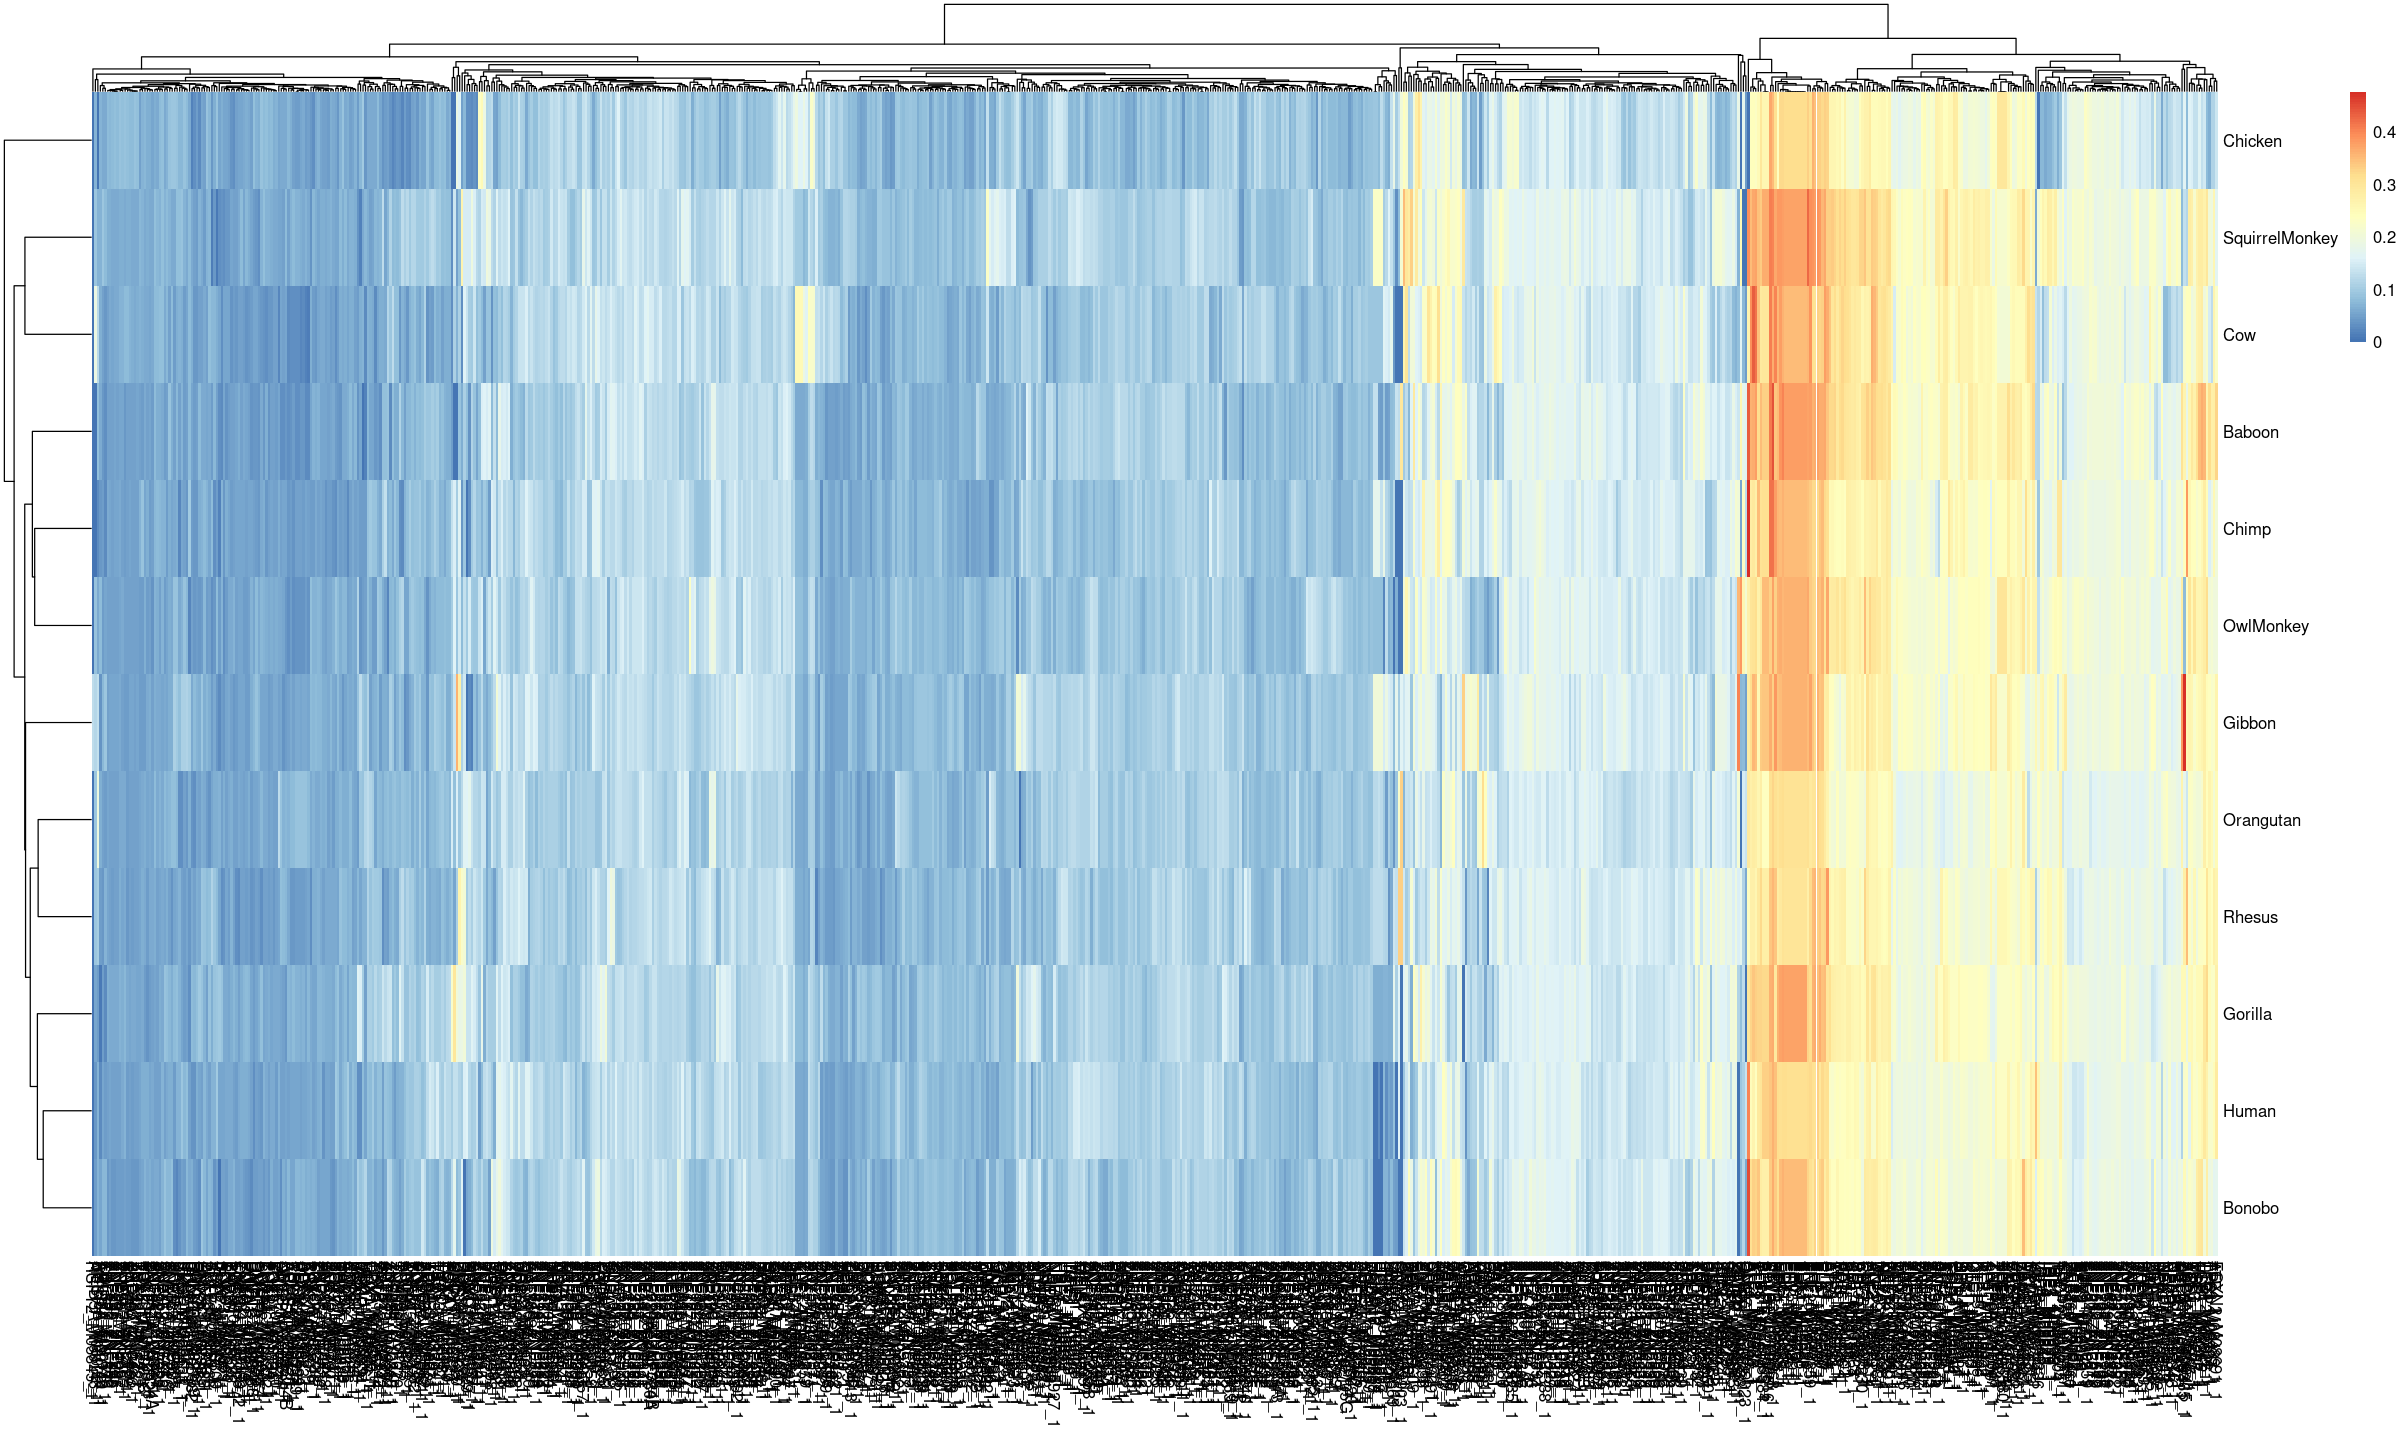

In [5]:
# Defines variables.

##############################
       # DMSO heatmap
##############################

condition <- "DMSO"

# Initializing data frame that will hold the MD scores across species.
md_species <- data.frame(matrix(nrow = dim(motifs)[1], ncol = length(speciesList)))
colnames(md_species) <- speciesList
rownames(md_species) <- motifs$V1

# Loading all the MD scores tables for all species
for(species in speciesList) {
    md_table <- read.table(paste0("/scratch/Users/dara6367/fimo/",species,"/TFs-",species,"-",speciesDict[species,"assembly"],"-",condition,"-",TFdb,"-",bg,"-FIMO_",alpha,"-intersect-tfit-bidirs.txt"), 
                           header = TRUE, sep = "\t", fill = TRUE, stringsAsFactors = FALSE, na.strings = "")
    md_table$core_fraction <- md_table$core / md_table$extended
    md_species[,species] <- md_table$core_fraction }

# Removes motif entries with NAs.
md_species <- md_species[complete.cases(md_species),]

# Removes Gibbon outlier
md_species <- md_species[!(rownames(md_species) == "MA0749_1_ZBED1"),]

# Obtains the order of TF motifs from the DMSO condition, and uses it for both DMSO and Nutlin.
md_species_t <- t(md_species)
heatmapData <- pheatmap(mat = md_species_t,
                        cluster_rows = TRUE, 
                        cluster_cols = TRUE,)

heatmapTForder <- colnames(md_species_t[,heatmapData$tree_col[["order"]]])

# Makes an annotation layer to show where TP53 is in the heatmap.
heatmapAnnot <- data.frame(matrix(ncol = 1, nrow = length(heatmapTForder)))
rownames(heatmapAnnot) <- heatmapTForder
colnames(heatmapAnnot) <- "TP53"
heatmapAnnot$TP53 <- as.factor(heatmapTForder == "MA0106_3_TP53")

heatmapAnnotColors <- list(TP53 = c("black","white"))
names(heatmapAnnotColors$TP53) <- c(FALSE, TRUE)

# Assigns the dendrogram order to the matrix.
md_species_t <- md_species_t[,heatmapTForder]

# Plots heatmap.
options(repr.plot.width = 24, repr.plot.height = 8)
pheatmap(mat = md_species_t,
         color = magmas,
         breaks = seq(from = 0, to = 0.700, by = (0.700/100)),
#         legend_breaks = seq(from = 0, to = 1, by = 0.1),
#         legend_labels = seq(from = 0, to = 1, by = 0.1),
         border_color = NA,
         show_colnames = FALSE,
         show_rownames = TRUE,
         cluster_rows = FALSE, 
         cluster_cols = FALSE,
         main = paste0(TFdb, " (n = ", dim(motifs)[1],")\n",condition),
         fontsize = 18,
         legend = TRUE,
         scale = "none",
         annotation_col = heatmapAnnot,
         annotation_colors = heatmapAnnotColors)

##############################
       # Nutlin heatmap
##############################

condition <- "Nutlin"

# Initializing data frame that will hold the MD scores across species.
md_species <- data.frame(matrix(nrow = dim(motifs)[1], ncol = length(speciesList)))
colnames(md_species) <- speciesList
rownames(md_species) <- motifs$V1

# Loading all the MD scores tables for all species
for(species in speciesList) {
    md_table <- read.table(paste0("/scratch/Users/dara6367/fimo/",species,"/TFs-",species,"-",speciesDict[species,"assembly"],"-",condition,"-",TFdb,"-",bg,"-FIMO_",alpha,"-intersect-tfit-bidirs.txt"), 
                           header = TRUE, sep = "\t", fill = TRUE, stringsAsFactors = FALSE, na.strings = "")
    md_table$core_fraction <- md_table$core / md_table$extended
    md_species[,species] <- md_table$core_fraction }

# Removes motif entries with NAs.
md_species <- md_species[complete.cases(md_species),]

# Removes Gibbon outlier
md_species <- md_species[!(rownames(md_species) == "MA0749_1_ZBED1"),]

# Obtains the order of TF motifs from the DMSO condition, and uses it for both DMSO and Nutlin.
md_species_t <- t(md_species)
md_species_t <- md_species_t[,heatmapTForder]

# Plots heatmap.
options(repr.plot.width = 24, repr.plot.height = 8)
pheatmap(mat = md_species_t,
         color = magmas,
         breaks = seq(from = 0, to = 0.700, by = (0.700/100)),
#         legend_breaks = seq(from = 0, to = 1, by = 0.1),
#         legend_labels = seq(from = 0, to = 1, by = 0.1),
         border_color = NA,
         show_colnames = FALSE,
         show_rownames = TRUE,
         cluster_rows = FALSE, 
         cluster_cols = FALSE,
         main = paste0(TFdb, " (n = ", dim(motifs)[1],")\n",condition),
         fontsize = 18,
         legend = TRUE,
         scale = "none",
         annotation_col = heatmapAnnot,
         annotation_colors = heatmapAnnotColors)

## Barcodes across species for chosen TF

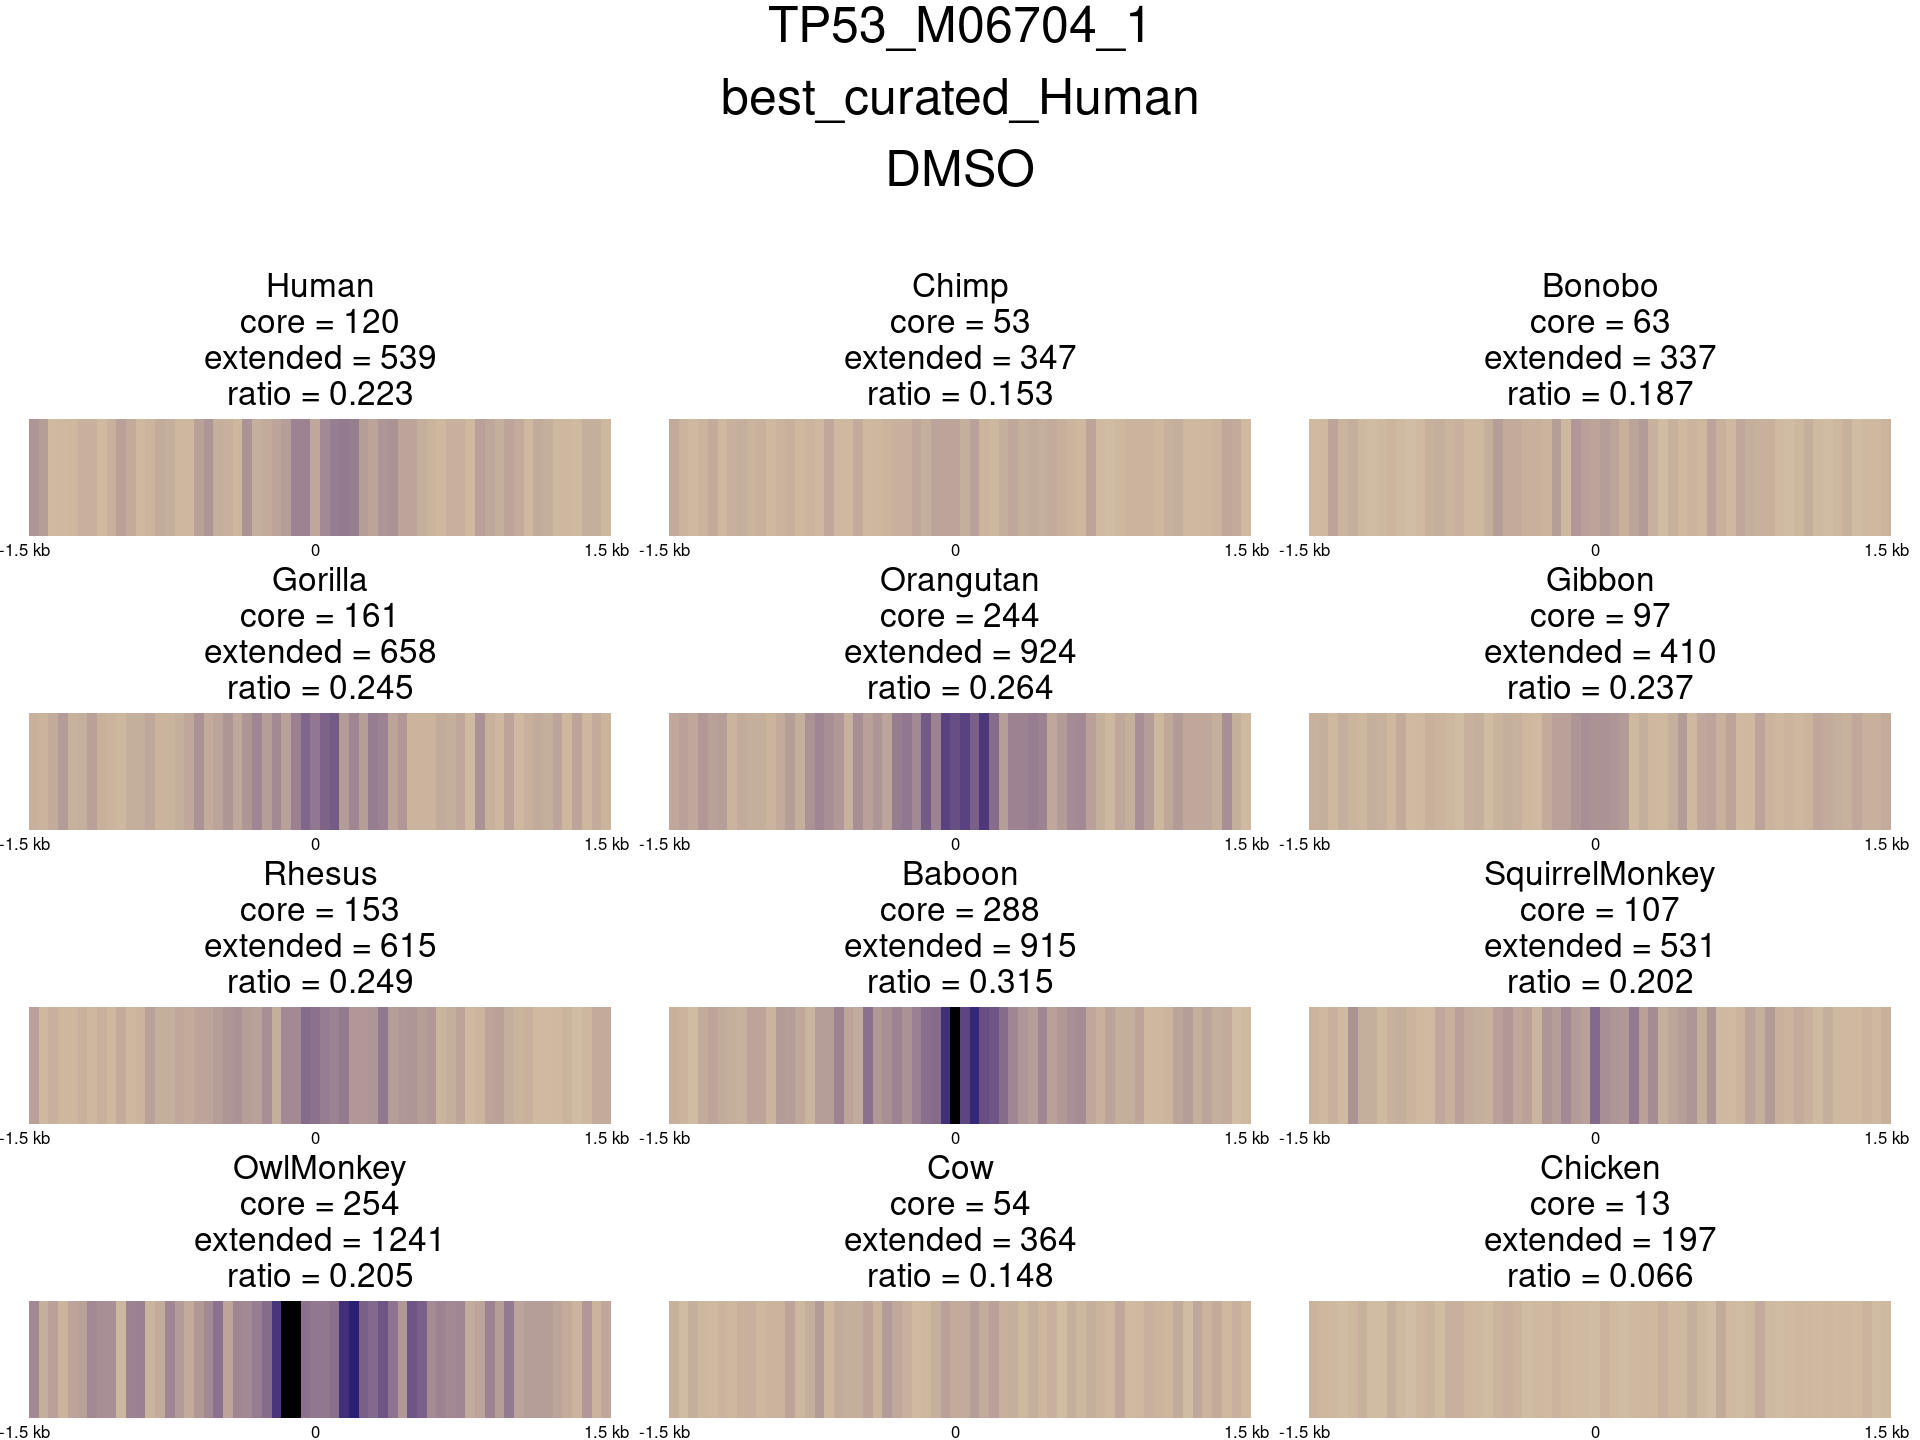

In [25]:
# Defines what motif to make a barcode with.

motif <- "TP53_M06704_1"
condition <- "DMSO"

# Initializes the data frame that will contain the max values for bins for each species.
maxBinN <- data.frame(matrix(nrow = length(speciesList), ncol = 1))
colnames(maxBinN) <- "max"
rownames(maxBinN) <- speciesList

# Loops through each species and obtains the max binned value for the chosen motif.
for(species in speciesList) {
    
    # Loads table contain the chosen motif positions.
    motifPositions <- read.table(paste0("/scratch/Users/dara6367/fimo/",species,"/",species,"-",speciesDict[species,"assembly"],"-",condition,"-",TFdb,"-",bg,"-",alpha,"-tfit-positions3kb/",motif,".relative3kb.positions"), 
                               header = FALSE, sep = "\t", fill = TRUE, stringsAsFactors = FALSE, na.strings = "")
    colnames(motifPositions) <- "positions"

    # Creates data frame that will contain the binned instances of chosen motif around bidirs.
    motifPositionsBins <- data.frame(matrix(0, ncol = 2, nrow = 60))
    colnames(motifPositionsBins) <- c("positionBins","counts")
    motifPositionsBins$positionBins <- seq(from = 50, to = 3000, by = 50)
    rownames(motifPositionsBins) <- seq(from = 50, to = 3000, by = 50)

    for(bin in seq(from = 50, to = 3000, by = 50)) {
        motifPositionsBins[motifPositionsBins$positionBins == bin,"counts"] <- sum(motifPositions$positions[motifPositions$positions %in% seq(from = bin-49, to = bin)] / 
                                                                                   motifPositions$positions[motifPositions$positions %in% seq(from = bin-49, to = bin)]) }
    maxBinN[species,"max"] <- max(motifPositionsBins$counts)
}

# Assigns the highest value from all max values across species.
#maxBinN <- max(maxBinN$max)
maxBinN <- 60

# Loops through each species and obtains the max binned value for the chosen motif.
for(species in speciesList) {
    
    # Loads table contain the chosen motif positions.
    motifPositions <- read.table(paste0("/scratch/Users/dara6367/fimo/",species,"/",species,"-",speciesDict[species,"assembly"],"-",condition,"-",TFdb,"-",bg,"-",alpha,"-tfit-positions3kb/",motif,".relative3kb.positions"), 
                               header = FALSE, sep = "\t", fill = TRUE, stringsAsFactors = FALSE, na.strings = "")
    colnames(motifPositions) <- "positions"
    
    # Creates data frame that will contain the binned instances of chosen motif around bidirs.
    motifPositionsBins <- data.frame(matrix(0, ncol = 2, nrow = 60))
    colnames(motifPositionsBins) <- c("positionBins","counts")
    motifPositionsBins$positionBins <- seq(from = 50, to = 3000, by = 50)
    rownames(motifPositionsBins) <- seq(from = 50, to = 3000, by = 50)

    for(bin in seq(from = 50, to = 3000, by = 50)) {
        motifPositionsBins[motifPositionsBins$positionBins == bin,"counts"] <- sum(motifPositions$positions[motifPositions$positions %in% seq(from = bin-49, to = bin)] / 
                                                                                   motifPositions$positions[motifPositions$positions %in% seq(from = bin-49, to = bin)]) }

    # Loads table contain the chosen motif counts.
    motifCounts <- read.table(paste0("/scratch/Users/dara6367/fimo/",species,"/TFs-",species,"-",speciesDict[species,"assembly"],"-",condition,"-",TFdb,"-",bg,"-FIMO_",alpha,"-intersect-tfit-bidirs.txt"), 
                              header = TRUE, sep = "\t", fill = TRUE, stringsAsFactors = FALSE, na.strings = "")
    
    # Stores barcode.
    barcode <- ggplot(motifPositionsBins, aes_string("positionBins", 1, fill = "counts")) +
        geom_tile() +
        scale_fill_gradient2(low = "white",
                             mid = "bisque3",
                             high = "midnightblue",
                             na.value = "black",
                             midpoint = (max(motifPositionsBins$counts)-min(motifPositionsBins$counts))/2,
                             name = NULL,
                             limits = c(0,maxBinN)) +
        theme_void() +
        labs(title = paste0(species, 
                            "\ncore = ",motifCounts[motifCounts$motif == motif,"core"],
                            "\nextended = ", motifCounts[motifCounts$motif == motif,"extended"],
                            "\nratio = ",signif(motifCounts[motifCounts$motif == motif,"core"]/motifCounts[motifCounts$motif == motif,"extended"],3))) +
        theme(axis.text.x = element_text(size = 10), 
              plot.title = element_text(size = 20, hjust = 0.5),
              legend.position = "none") +
        scale_x_continuous(breaks = c(0,1500,3000), labels = c("-1.5 kb","0","1.5 kb"))
    
    # Puts species name to the barcode variable name.
    assign(paste0("barcode_",species), barcode)
}

# Plots all barcodes in a grid.
options(repr.plot.width = 16, repr.plot.height = 12)
grid.arrange(barcode_Human,barcode_Chimp,barcode_Bonobo,barcode_Gorilla,
             barcode_Orangutan,barcode_Gibbon,barcode_Rhesus,barcode_Baboon,
             barcode_SquirrelMonkey,barcode_OwlMonkey,barcode_Cow,barcode_Chicken,
             ncol = 3, nrow = 4,
             top = textGrob(paste0(motif,"\n",TFdb,"\n",condition,"\n"), 
                            gp = gpar(fontsize = 30)))